# Invasive Ductal Carcinoma Detection Model

## Imports

In [158]:
import numpy as np 
import pandas as pd 
from collections import Counter
import os
from pathlib import Path
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

## Exploratory Analysis

In [211]:
from os import listdir
from skimage.io import imread
base_path = r"C:\Users\ericl\Downloads\data\8950"
folder = listdir(base_path)
len(folder)

2

In [212]:
total_images = 0
for n in range(len(folder)):
    for c in [0, 1]:
        class_path = base_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)
total_images

1220

In [213]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

data.head()

patient_id                                               path target
0          0  C:\Users\ericl\Downloads\data\8950/0/8950_idx5...      0
1          0  C:\Users\ericl\Downloads\data\8950/0/8950_idx5...      0
2          0  C:\Users\ericl\Downloads\data\8950/0/8950_idx5...      0
3          0  C:\Users\ericl\Downloads\data\8950/0/8950_idx5...      0
4          0  C:\Users\ericl\Downloads\data\8950/0/8950_idx5...      0

In [214]:
data.shape

(1220, 3)

In [215]:
data.target = data.target.astype(int)

In [216]:
pos_selection = np.random.choice(data[data.target==1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target==0].index.values, size=50, replace=False)

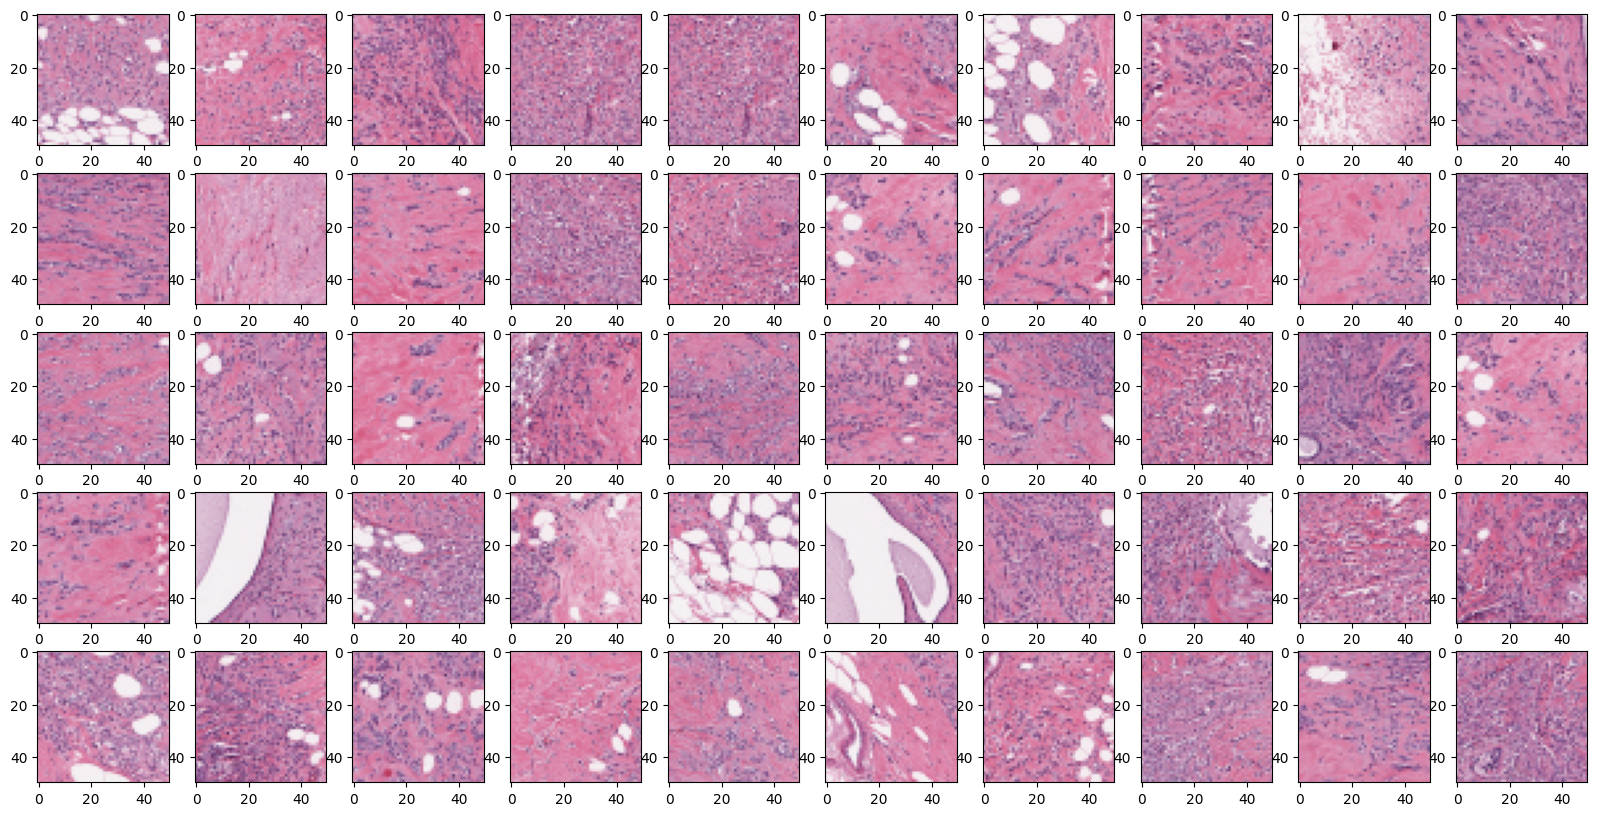

In [217]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

### Healthy Patch

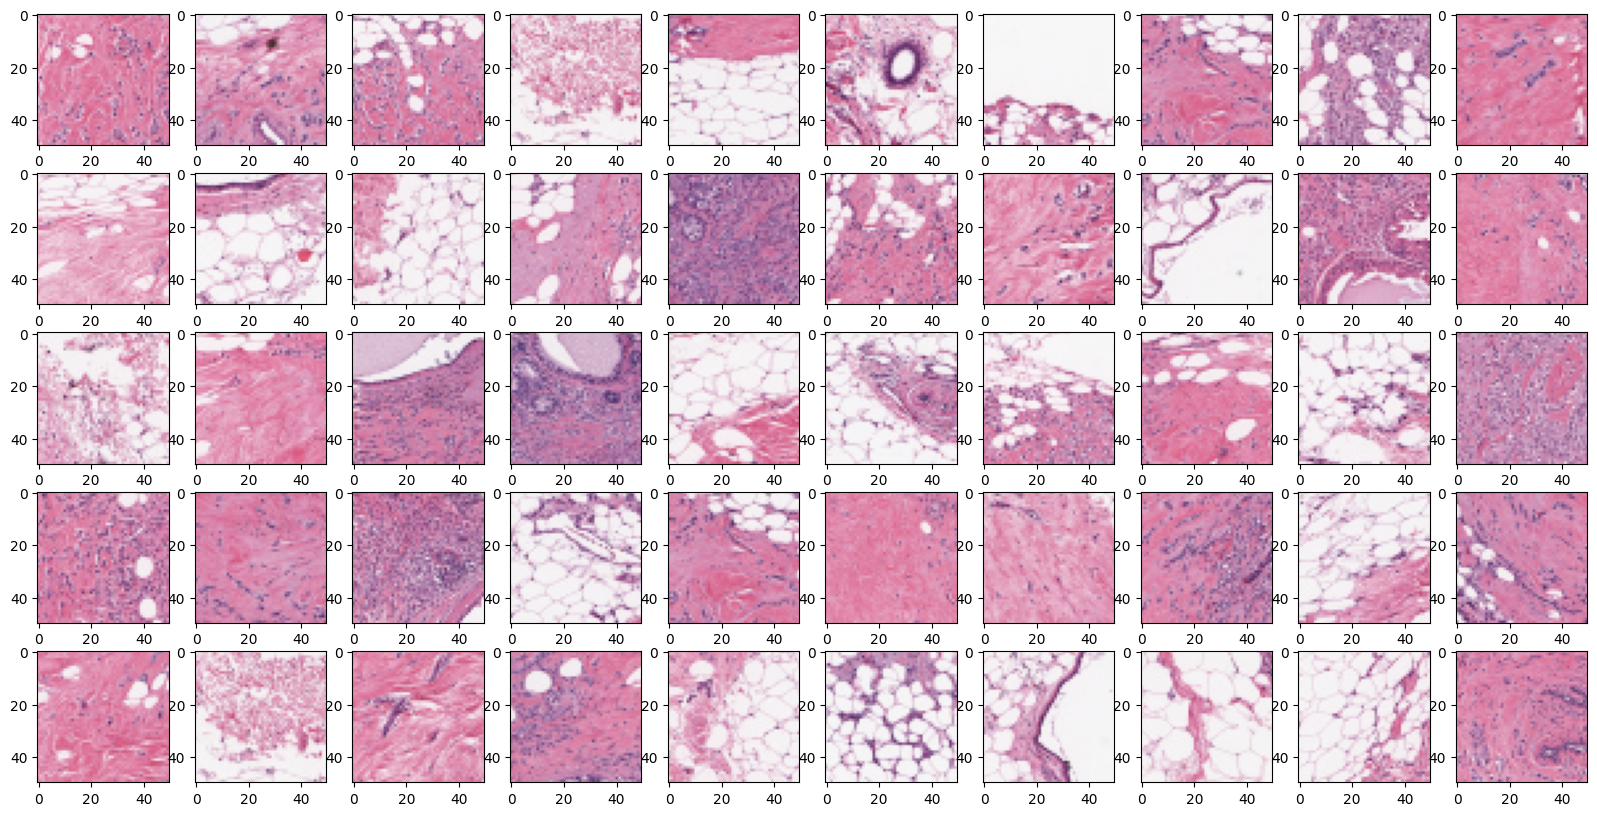

In [218]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

In [219]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    path = base_path  + "/" + cancer_id
    files = listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = pd.concat([df_0, df_1], ignore_index=True)
    return patient_df



In [220]:
example = get_patient_dataframe(data.patient_id.values[0])
example.head()

x     y  target                                               path
0  1001  1001       0  C:\Users\ericl\Downloads\data\8950/0/8950_idx5...
1  1001  1051       0  C:\Users\ericl\Downloads\data\8950/0/8950_idx5...
2  1001  1101       0  C:\Users\ericl\Downloads\data\8950/0/8950_idx5...
3  1001  1151       0  C:\Users\ericl\Downloads\data\8950/0/8950_idx5...
4  1001  1201       0  C:\Users\ericl\Downloads\data\8950/0/8950_idx5...

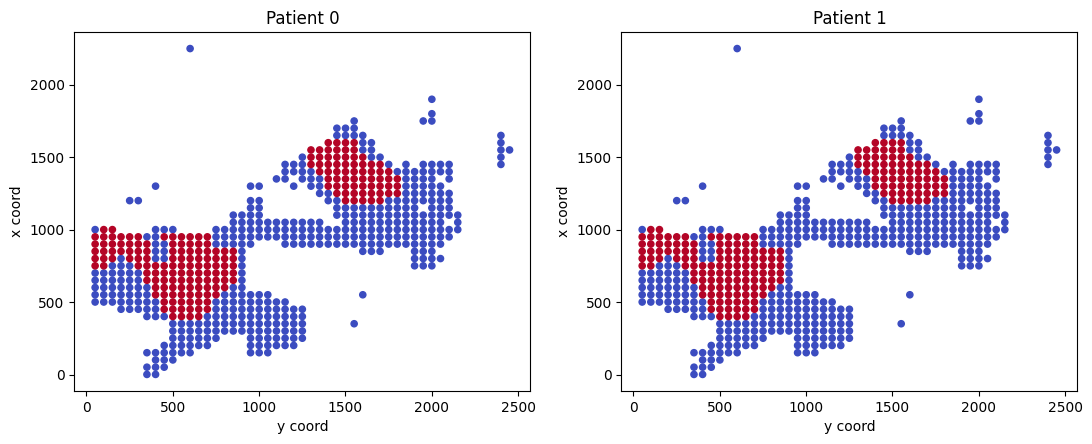

In [221]:
fig, ax = plt.subplots(5, 3, figsize=(20, 27))

patient_ids = data.patient_id.unique()

for n in range(5):
    for m in range(3):
        try:
            patient_index = n * 3 + m
            if patient_index < len(patient_ids):  # Make sure the index is within the range
                patient_id = patient_ids[patient_index]
                example_df = get_patient_dataframe(patient_id)

                ax[n, m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20)
                ax[n, m].set_title("Patient " + patient_id)
                ax[n, m].set_xlabel("y coord")
                ax[n, m].set_ylabel("x coord")
            else:
                ax[n, m].set_visible(False)  # Hide unused subplots if there are no more patient IDs
        except IndexError as e:
            print(f"An IndexError occurred: {e}")  # Optionally print an error message
            ax[n, m].set_visible(False)  # Hide the subplot that caused the error


In [222]:
def visualise_breast_tissue(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coord = int(example_df.x.values[n])
            y_coord = int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                
                proba = patient_df[
                    (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = np.float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba

Text(0.5, 1.0, 'Cancer tissue colored red \n of patient: 1')

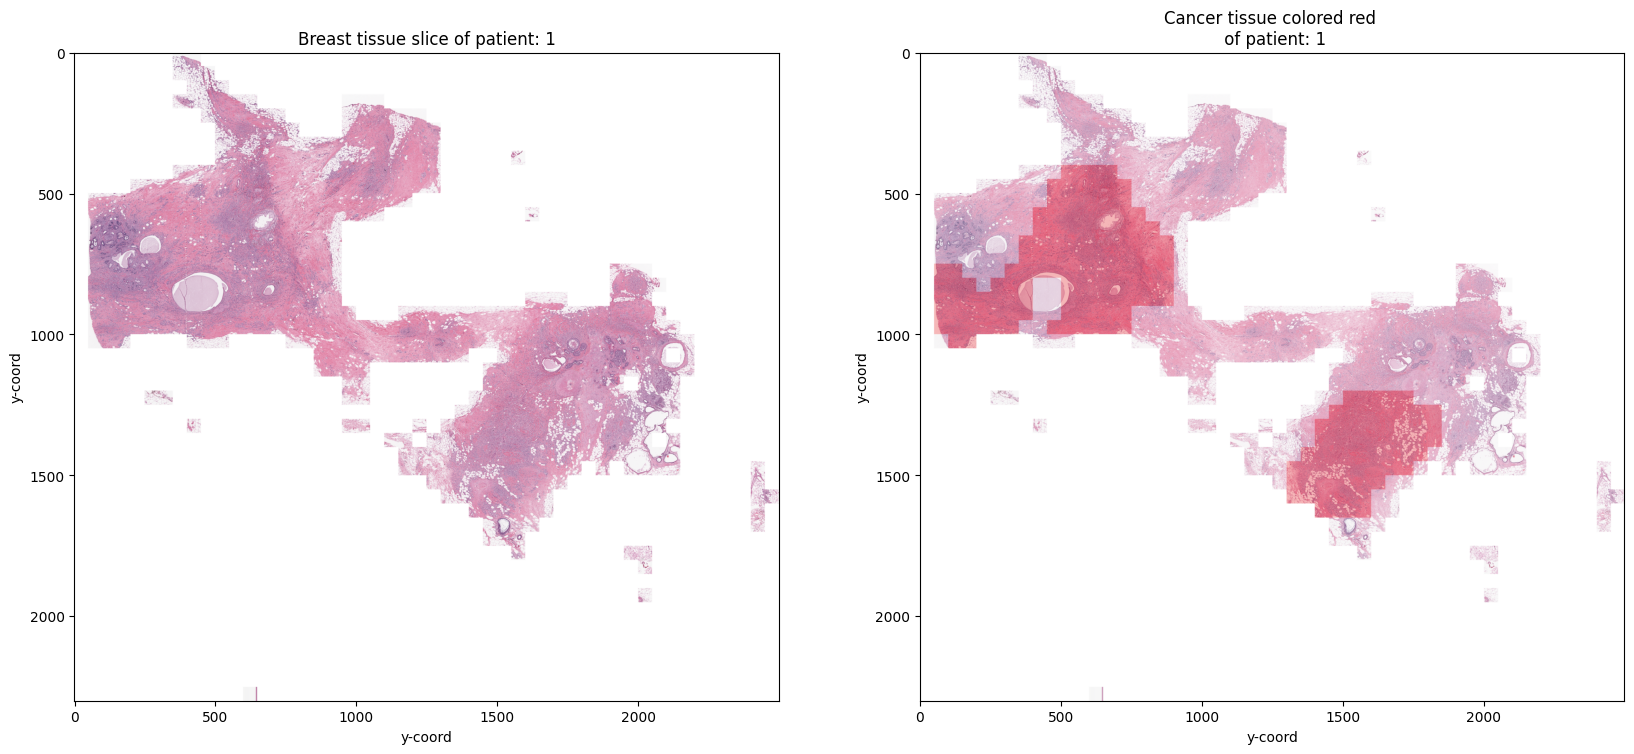

In [223]:
example = "8950"
grid, mask, broken_patches,_ = visualise_breast_tissue(example)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(grid, alpha=0.9)
ax[1].imshow(mask, alpha=0.8)
ax[1].imshow(grid, alpha=0.7)
ax[0].grid(False)
ax[1].grid(False)
for m in range(2):
    ax[m].set_xlabel("y-coord")
    ax[m].set_ylabel("y-coord")
ax[0].set_title("Breast tissue slice of patient: " + patient_id)
ax[1].set_title("Cancer tissue colored red \n of patient: " + patient_id)

## Data Loading

In [49]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for user_folder in self.root_dir.iterdir():
            if user_folder.is_dir():
                for class_folder in user_folder.iterdir():
                    if class_folder.is_dir():
                        label = int(class_folder.name)
                        for img_path in class_folder.glob('*.png'):
                            self.image_paths.append(img_path)
                            self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = torch.tensor(self.labels[idx],dtype =torch.float).view(-1)
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.471, 0.448, 0.408], std=[0.234, 0.239, 0.242])
])

# Create dataset
root_dir = r'C:\Users\ericl\Downloads\data\170'
dataset = CustomImageDataset(root_dir=root_dir, transform=transform)

# Create data loader
batch_size = 512
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Check the structure of our dataloader
for images, labels in dataloader:
    print("Batch of images:", images.size())
    print("Batch of labels:", labels.size())
    break

Batch of images: torch.Size([512, 3, 64, 64])
Batch of labels: torch.Size([512, 1])


## Data Splitting, Ratio of Train, Test and Validation is 0.7,0.15,0.15

In [57]:
from torch.utils.data import random_split

# Define the size of each split
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
torch.manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders for each set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check by iterating through the train_loader
input_try, label_try = next(iter(train_loader))
print('Batch of images:', input_try.size())
print('Batch of labels:', label_try.size())

Batch of images: torch.Size([512, 3, 64, 64])
Batch of labels: torch.Size([512, 1])


In [51]:
def imshow(inp, title=None):
#   Imshow for Tensor.
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = np.clip(std * inp + mean, 0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

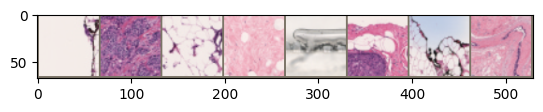

In [52]:
# Glim of Training Data
out = torchvision.utils.make_grid(input_try[0:8,:,:,:])
imshow(out)

### Check the size of each dataset with labels counts.


In [6]:
def count_classes_no_loop(original_dataset, subset):
    # Extract the labels for the indices in the subset
    subset_labels = [original_dataset.labels[i] for i in subset.indices]
    # Count the occurrences of each class
    class_0_count = subset_labels.count(0)
    class_1_count = subset_labels.count(1)
    return {0: class_0_count, 1: class_1_count}

# Assuming 'dataset' is your original dataset
train_counts = count_classes_no_loop(dataset, train_dataset)
val_counts = count_classes_no_loop(dataset, val_dataset)
test_counts = count_classes_no_loop(dataset, test_dataset)

print(f"Training set: {train_counts}")
print(f"Validation set: {val_counts}")
print(f"Test set: {test_counts}")



Training set: {0: 83796, 1: 36623}
Validation set: {0: 18037, 1: 7767}
Test set: {0: 17938, 1: 7867}


### Architecture 1: Net

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layers (adjust the input size accordingly)
        self.fc1 = nn.Linear(64 * 8 * 8, 500)  # Adjust the size
        #self.fc2 = nn.Linear(1024, 512) 
        self.fc2 = nn.Linear(500,1) # Adjust for multi-class if needed
        # dropout layer
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 64 * 8 * 8)  # Adjust to match your final conv layer size
        # dropout and fully connected layers
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


Check availability of GPU

In [3]:
# Use GPU if available. If not, use cpu instead
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Using gpu: %s' %torch.cuda.is_available())

Using gpu: True


### Define the test loop

In [72]:
def test_model(model, test_loader, criterion, test = False, device = device, pt_name = "", network = None):
    if test:
        
        model = network
        pt_path = "{}\\".format(os.getcwd()) + pt_name
        state_dict = torch.load(pt_path)
        model.load_state_dict(state_dict)
    # turn model to evaluation mode
    model.eval()
    # model to device
    model.to(device)
    
    # record true positive, false positive, and false negative number of predictions for F1 score
    tp = 0.0
    fp = 0.0
    fn = 0.0
    
    # record correct and total number of predictions
    correct = 0.0
    total = 0.0
    
    # initialzie test_loss
    test_loss = 0.0
    
    # turn off gradient
    with torch.no_grad():
        # iterate through test data loader
        for data, target in test_loader:
            # move data and true label to device
            data, target = data.to(device), target.to(device)
            # predict logits with data
            output = model(data)
            # calcualte test loss and record test loss
            loss = criterion(output,target)
            test_loss += loss.item()
            
            # transfer predicted logits to probability
            output = torch.sigmoid(output)
            # Obtain predicted classification with 0.5 threshhold 
            pred = torch.round(output)
            # update correct predictions
            correct += (pred == target).sum().item()
            # update total predictions
            total += target.size(0)
            # update true positive
            tp += torch.sum((pred == 1) & (target == 1)).item()
            # update false positive
            fp += torch.sum((pred == 1) & (target == 0)).item()
            # update false negative
            fn += torch.sum((pred == 0) & (target == 1)).item()
    
    # overall accuracy 
    accuracy = correct/total
    # f1 score
    recall = tp/(tp+fn) if tp+fn >0 else 0
    precision = tp/(tp+fp) if tp + fp >0 else 0
    f_score = 2*recall*precision/(precision+recall) if precision +recall >0 else 0
    # test loss  
    test_loss = test_loss/len(test_loader)
    
    if test:
        print('Test Accuracy: {:.6f} \tTest F Score: {:.6f}'.format(accuracy, f_score))

    return test_loss, accuracy, f_score

### Define the Train Loop

In [88]:
def train_model(model, train_loader, valid_loader, epoch, optimizer, criterion, model_name = 'model', device = device):
    # number of epoches to train
    n_epochs = epoch

    valid_loss_min = np.Inf #track chagne in validation loss
    train_losses = []
    valid_losses = []
    accuracies = []
    f_scores = []
    
    for epoch in range(1, n_epochs+1):
        # timer
        start_time = time.time()
        train_loss = 0.0
        valid_loss = 0.0
        ###################
        # train the model #
        ###################
        model.train()
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
        for batch_idx, (data, target) in progress_bar:
            data, target = data.to(device), target.to(device)
    
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            progress_bar.set_description(f'Epoch: {epoch}/{n_epochs}, Batch: {batch_idx}/{len(train_loader)}')
        ######################
        # validate the model #
        ######################
        print('Validation starts!')
        valid_loss, accuracy, f_score = test_model(model,valid_loader, criterion, device = device)
        
        # calculate and record average losses
        train_loss = train_loss / len(train_loader)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        accuracies.append(accuracy)
        f_scores.append(f_score)

        # epoch time
        end_time = time.time()
        epoch_time = end_time - start_time
        
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f} \tF_score: {:.6f}'.format
              (epoch, train_loss, valid_loss, accuracy, f_score))
        print('Time of Epoch: {:.0f} minutes {:.0f} seconds'.format(epoch_time//60, epoch_time%60))
        
        # save model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(valid_loss_min, valid_loss))
            file_path = f'{model_name}.pt'
            torch.save(model.state_dict(), file_path)
            valid_loss_min = valid_loss 
    
    return train_losses, valid_losses, accuracies, f_scores 

### Define plot functions

In [6]:
def plot_loss(train_losses, valid_losses, num_epochs):
    plt.figure(figsize=(10, 7))
    plt.plot(range(1, num_epochs + 1),train_losses, label =  'Training loss')
    plt.plot(range(1, num_epochs + 1),valid_losses, label = 'valid_losses')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.grid(True)
    plt.show()
def plot_accurate(accuracies, f_scores, num_epochs):
    plt.figure(figsize=(10, 7))
    plt.plot(range(1, num_epochs + 1),accuracies, label =  'Accuracy')
    plt.plot(range(1, num_epochs + 1),f_scores, label = 'F Score')
    plt.xlabel('epoch')
    plt.ylabel('Percentage')
    plt.legend()
    plt.grid(True)
    plt.title('Accuracy and F Score')
    plt.show()

### Build baseline model

In [148]:
baseline_nn = Net()
baseline_nn = baseline_nn.to(device)
baseline_nn

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

### baseline hyperparameters

In [118]:
# specify loss function (categorical cross-entropy)
pos_weight = torch.tensor([4.0])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)

# specify optimizer
optimizer = optim.Adam(baseline_nn.parameters(), lr=0.007)

### Train baseline

In [13]:
train_losses_base, valid_losses_base, accuracies_base, f_scores_base = train_model(baseline_nn, train_loader, val_loader, 50, optimizer, criterion, model_name = 'baseline_nn')

Epoch 1 starts! Please wait..
Validation starts!
Epoch: 1 	Training Loss: 1.121346 	Validation Loss: 0.815912 	Validation Accuracy: 0.840025 	F_score: 0.748660
Time of Epoch: 5 minutes 27 seconds
Validation loss decreased (inf --> 0.815912). Saving model ...
Epoch 2 starts! Please wait..
Validation starts!
Epoch: 2 	Training Loss: 0.663460 	Validation Loss: 0.906068 	Validation Accuracy: 0.598783 	F_score: 0.593218
Time of Epoch: 2 minutes 57 seconds
Epoch 3 starts! Please wait..
Validation starts!
Epoch: 3 	Training Loss: 0.639318 	Validation Loss: 0.632284 	Validation Accuracy: 0.828825 	F_score: 0.758937
Time of Epoch: 2 minutes 55 seconds
Validation loss decreased (0.815912 --> 0.632284). Saving model ...
Epoch 4 starts! Please wait..
Validation starts!
Epoch: 4 	Training Loss: 0.620365 	Validation Loss: 0.756499 	Validation Accuracy: 0.723841 	F_score: 0.668589
Time of Epoch: 2 minutes 60 seconds
Epoch 5 starts! Please wait..
Validation starts!
Epoch: 5 	Training Loss: 0.610444 	V

### Plot baseline model metrics

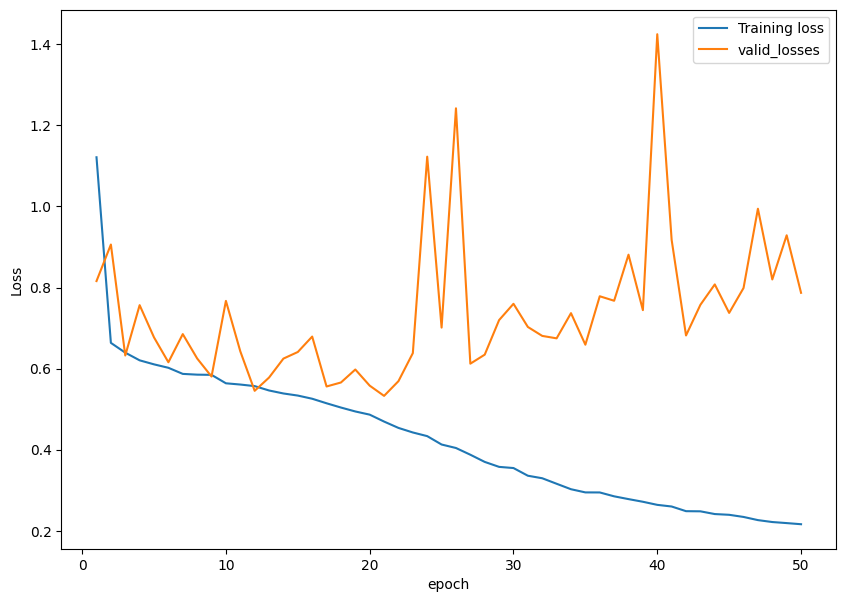

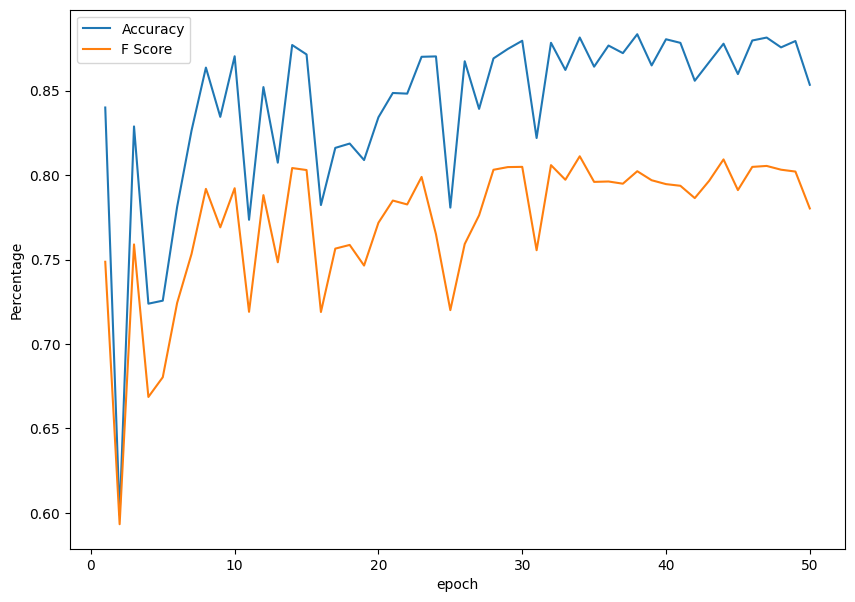

In [28]:
plot_loss(train_losses_base, valid_losses_base, 50)
plot_accurate(accuracies_base, f_scores_base, 50)

### baseline Prediction Accuracy and F1 score

In [58]:
test_loss_base, accuracy_base, f_score_base = test_model(baseline_nn, test_loader, criterion, test = True, device = device, pt_name ='baseline_nn.pt', network = Net())

Test Accuracy: 0.847781 	Test F Score: 0.786033


### Normalize and resize images to use vgg16

In [9]:
# normalization of input to fit vgg16 model
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
vgg_dataset = CustomImageDataset(root_dir=root_dir, transform=transform)
vgg_batch = 128
vgg_dataloader = DataLoader(vgg_dataset, batch_size=vgg_batch, shuffle=True)

from torch.utils.data import random_split

# Define the size of each split
total_size = len(vgg_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
torch.manual_seed(48)
vgg_train_dataset, vgg_val_dataset, vgg_test_dataset = random_split(vgg_dataset, [train_size, val_size, test_size])

# Create data loaders for each set
vgg_train_loader = DataLoader(vgg_train_dataset, batch_size=vgg_batch, shuffle=True)
vgg_val_loader = DataLoader(vgg_val_dataset, batch_size=vgg_batch, shuffle=False)
vgg_test_loader = DataLoader(vgg_test_dataset, batch_size=vgg_batch, shuffle=False)

In [17]:
model_vgg = models.vgg16(weights = 'DEFAULT')

In [206]:
for param in model_vgg.parameters():
    param.requires_grad = False
model_vgg.classifier._modules['6'] = nn.Linear(4096, 1)
model_vgg.classifier._modules['0'] = nn.Linear(25088, 256)
model_vgg.classifier._modules['2'] = nn.Dropout(p = 0.2)
model_vgg.classifier._modules['3'] = nn.Linear(256,128)
model_vgg.classifier._modules['5'] = nn.Dropout(p = 0.2)
model_vgg.classifier._modules['6'] = nn.Linear(128,1)
print(model_vgg)
model_vgg = model_vgg.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### VGG hyperparameters

In [22]:
vgg_optimizer = optim.Adam(model_vgg.classifier[0:6].parameters(), lr = 0.007)
pos_weight = torch.tensor([4.0])
vgg_criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight).to(device)

### Train VGG

In [23]:
train_losses_vgg, valid_losses_vgg, accuracies_vgg, f_scores_vgg = train_model(model_vgg, vgg_train_loader, vgg_val_loader, 25, vgg_optimizer, vgg_criterion, model_name = 'vgg')

Epoch 1 starts! Please wait..
Validation starts!
Epoch: 1 	Training Loss: 0.743335 	Validation Loss: 0.660533 	Validation Accuracy: 0.814719 	F_score: 0.747531
Time of Epoch: 29 minutes 14 seconds
Validation loss decreased (inf --> 0.660533). Saving model ...
Epoch 2 starts! Please wait..
Validation starts!
Epoch: 2 	Training Loss: 0.623966 	Validation Loss: 0.644594 	Validation Accuracy: 0.818904 	F_score: 0.751449
Time of Epoch: 27 minutes 57 seconds
Validation loss decreased (0.660533 --> 0.644594). Saving model ...
Epoch 3 starts! Please wait..
Validation starts!
Epoch: 3 	Training Loss: 0.562008 	Validation Loss: 0.648377 	Validation Accuracy: 0.820803 	F_score: 0.751958
Time of Epoch: 28 minutes 22 seconds
Epoch 4 starts! Please wait..
Validation starts!
Epoch: 4 	Training Loss: 0.511035 	Validation Loss: 0.685311 	Validation Accuracy: 0.809564 	F_score: 0.741259
Time of Epoch: 28 minutes 12 seconds
Epoch 5 starts! Please wait..
Validation starts!
Epoch: 5 	Training Loss: 0.45609

KeyboardInterrupt: 

### VGG prediction accuracy and f1 score

In [16]:
vgg_test = models.vgg16(weights = 'DEFAULT')
vgg_test.classifier[6] = model_vgg.classifier._modules['6'] = nn.Linear(4096, 1)
test_loss_vgg, accuracy_vgg, f_score_vgg = test_model(model_vgg, vgg_test_loader, vgg_criterion, test = True, device = device, pt_name ='vgg.pt', network = vgg_test)

Test Accuracy: 0.804534 	Test F Score: 0.737811


### Architecture 2: Net2

In [80]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding = 1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.2)

        self.fc1 = nn.Linear(256*8*8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 256*8*8)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return x
    

### Build base_tune model

In [86]:
base_tune = Net2().to(device)
base_tune

Net2(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)

### base_tune hyperparameters

In [89]:
optimizer_tune = optim.Adam(base_tune.parameters(), lr = 0.008)
pos_weight = torch.tensor([4])
criterion_tune = nn.BCEWithLogitsLoss(pos_weight = pos_weight).to(device)

### Train base_tune

In [90]:
train_losses_tune, valid_losses_tune, accuracies_tune, f_scores_tune = train_model(base_tune, train_loader, val_loader, 30, optimizer_tune, criterion_tune, model_name = 'base_tune')

Epoch: 1/30, Batch: 235/236: 100%|██████████████████████████████████████████████████| 236/236 [02:35<00:00,  1.52it/s]


Validation starts!
Epoch: 1 	Training Loss: 2.596276 	Validation Loss: 1.099363 	Validation Accuracy: 0.830336 	F_score: 0.712692
Time of Epoch: 3 minutes 3 seconds
Validation loss decreased (inf --> 1.099363). Saving model ...


Epoch: 2/30, Batch: 235/236: 100%|██████████████████████████████████████████████████| 236/236 [02:34<00:00,  1.52it/s]


Validation starts!
Epoch: 2 	Training Loss: 0.711786 	Validation Loss: 0.673797 	Validation Accuracy: 0.815339 	F_score: 0.746043
Time of Epoch: 3 minutes 2 seconds
Validation loss decreased (1.099363 --> 0.673797). Saving model ...


Epoch: 3/30, Batch: 235/236: 100%|██████████████████████████████████████████████████| 236/236 [02:32<00:00,  1.55it/s]


Validation starts!
Epoch: 3 	Training Loss: 0.697899 	Validation Loss: 0.689534 	Validation Accuracy: 0.832003 	F_score: 0.759527
Time of Epoch: 3 minutes 0 seconds


Epoch: 4/30, Batch: 235/236: 100%|██████████████████████████████████████████████████| 236/236 [02:35<00:00,  1.52it/s]


Validation starts!
Epoch: 4 	Training Loss: 0.666329 	Validation Loss: 0.621297 	Validation Accuracy: 0.826112 	F_score: 0.758906
Time of Epoch: 3 minutes 3 seconds
Validation loss decreased (0.673797 --> 0.621297). Saving model ...


Epoch: 5/30, Batch: 235/236: 100%|██████████████████████████████████████████████████| 236/236 [02:40<00:00,  1.47it/s]


Validation starts!
Epoch: 5 	Training Loss: 0.654504 	Validation Loss: 0.732193 	Validation Accuracy: 0.763525 	F_score: 0.701526
Time of Epoch: 3 minutes 10 seconds


Epoch: 6/30, Batch: 235/236: 100%|██████████████████████████████████████████████████| 236/236 [04:19<00:00,  1.10s/it]


Validation starts!
Epoch: 6 	Training Loss: 0.640297 	Validation Loss: 0.613457 	Validation Accuracy: 0.827042 	F_score: 0.759989
Time of Epoch: 5 minutes 2 seconds
Validation loss decreased (0.621297 --> 0.613457). Saving model ...


Epoch: 7/30, Batch: 235/236: 100%|██████████████████████████████████████████████████| 236/236 [05:08<00:00,  1.31s/it]


Validation starts!
Epoch: 7 	Training Loss: 0.628639 	Validation Loss: 0.666438 	Validation Accuracy: 0.836963 	F_score: 0.766109
Time of Epoch: 5 minutes 32 seconds


Epoch: 8/30, Batch: 235/236: 100%|██████████████████████████████████████████████████| 236/236 [02:21<00:00,  1.67it/s]


Validation starts!
Epoch: 8 	Training Loss: 0.619053 	Validation Loss: 0.590499 	Validation Accuracy: 0.807976 	F_score: 0.746819
Time of Epoch: 2 minutes 46 seconds
Validation loss decreased (0.613457 --> 0.590499). Saving model ...


Epoch: 9/30, Batch: 235/236: 100%|██████████████████████████████████████████████████| 236/236 [02:24<00:00,  1.63it/s]


Validation starts!
Epoch: 9 	Training Loss: 0.608205 	Validation Loss: 1.495446 	Validation Accuracy: 0.854131 	F_score: 0.726811
Time of Epoch: 2 minutes 49 seconds


Epoch: 10/30, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [02:23<00:00,  1.65it/s]


Validation starts!
Epoch: 10 	Training Loss: 0.598081 	Validation Loss: 0.675356 	Validation Accuracy: 0.756821 	F_score: 0.707173
Time of Epoch: 2 minutes 48 seconds


Epoch: 11/30, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [02:23<00:00,  1.65it/s]


Validation starts!
Epoch: 11 	Training Loss: 0.583418 	Validation Loss: 0.655729 	Validation Accuracy: 0.774144 	F_score: 0.719915
Time of Epoch: 2 minutes 48 seconds


Epoch: 12/30, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [02:22<00:00,  1.66it/s]


Validation starts!
Epoch: 12 	Training Loss: 0.571986 	Validation Loss: 0.761908 	Validation Accuracy: 0.846884 	F_score: 0.776817
Time of Epoch: 2 minutes 46 seconds


Epoch: 13/30, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [02:20<00:00,  1.68it/s]


Validation starts!
Epoch: 13 	Training Loss: 0.572988 	Validation Loss: 0.591417 	Validation Accuracy: 0.804294 	F_score: 0.746867
Time of Epoch: 2 minutes 44 seconds


Epoch: 14/30, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [02:20<00:00,  1.69it/s]


Validation starts!
Epoch: 14 	Training Loss: 0.566391 	Validation Loss: 0.551354 	Validation Accuracy: 0.833902 	F_score: 0.773419
Time of Epoch: 2 minutes 44 seconds
Validation loss decreased (0.590499 --> 0.551354). Saving model ...


Epoch: 15/30, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [02:20<00:00,  1.68it/s]


Validation starts!
Epoch: 15 	Training Loss: 0.548282 	Validation Loss: 0.557902 	Validation Accuracy: 0.830104 	F_score: 0.770207
Time of Epoch: 2 minutes 44 seconds


Epoch: 16/30, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [02:05<00:00,  1.88it/s]


Validation starts!
Epoch: 16 	Training Loss: 0.545776 	Validation Loss: 0.719277 	Validation Accuracy: 0.868974 	F_score: 0.800778
Time of Epoch: 2 minutes 28 seconds


Epoch: 17/30, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [02:05<00:00,  1.88it/s]


Validation starts!
Epoch: 17 	Training Loss: 0.541149 	Validation Loss: 0.669226 	Validation Accuracy: 0.882266 	F_score: 0.813688
Time of Epoch: 2 minutes 29 seconds


Epoch: 18/30, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [02:04<00:00,  1.89it/s]


Validation starts!
Epoch: 18 	Training Loss: 0.521803 	Validation Loss: 0.594879 	Validation Accuracy: 0.849481 	F_score: 0.783838
Time of Epoch: 2 minutes 28 seconds


Epoch: 19/30, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [02:05<00:00,  1.89it/s]


Validation starts!
Epoch: 19 	Training Loss: 0.520580 	Validation Loss: 0.807890 	Validation Accuracy: 0.809564 	F_score: 0.743982
Time of Epoch: 2 minutes 28 seconds


Epoch: 20/30, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [02:07<00:00,  1.85it/s]


Validation starts!
Epoch: 20 	Training Loss: 0.514178 	Validation Loss: 1.437520 	Validation Accuracy: 0.868005 	F_score: 0.765846
Time of Epoch: 2 minutes 31 seconds


Epoch: 21/30, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [02:06<00:00,  1.87it/s]


Validation starts!
Epoch: 21 	Training Loss: 0.491501 	Validation Loss: 0.600780 	Validation Accuracy: 0.832623 	F_score: 0.768852
Time of Epoch: 2 minutes 30 seconds


Epoch: 22/30, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [02:06<00:00,  1.87it/s]


Validation starts!
Epoch: 22 	Training Loss: 0.471963 	Validation Loss: 0.580037 	Validation Accuracy: 0.845954 	F_score: 0.783979
Time of Epoch: 2 minutes 30 seconds


Epoch: 23/30, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [02:04<00:00,  1.89it/s]


Validation starts!
Epoch: 23 	Training Loss: 0.458163 	Validation Loss: 0.617756 	Validation Accuracy: 0.849481 	F_score: 0.781503
Time of Epoch: 2 minutes 28 seconds


Epoch: 24/30, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [02:04<00:00,  1.90it/s]


Validation starts!
Epoch: 24 	Training Loss: 0.441057 	Validation Loss: 0.757161 	Validation Accuracy: 0.872655 	F_score: 0.805769
Time of Epoch: 2 minutes 28 seconds


Epoch: 25/30, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [02:04<00:00,  1.89it/s]


Validation starts!
Epoch: 25 	Training Loss: 0.427250 	Validation Loss: 1.144255 	Validation Accuracy: 0.876880 	F_score: 0.799495
Time of Epoch: 2 minutes 28 seconds


Epoch: 26/30, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [02:04<00:00,  1.89it/s]


Validation starts!
Epoch: 26 	Training Loss: 0.405442 	Validation Loss: 0.738061 	Validation Accuracy: 0.810107 	F_score: 0.751420
Time of Epoch: 2 minutes 29 seconds


Epoch: 27/30, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [02:06<00:00,  1.87it/s]


Validation starts!
Epoch: 27 	Training Loss: 0.375101 	Validation Loss: 0.820703 	Validation Accuracy: 0.885367 	F_score: 0.820531
Time of Epoch: 2 minutes 30 seconds


Epoch: 28/30, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [02:05<00:00,  1.88it/s]


Validation starts!
Epoch: 28 	Training Loss: 0.330885 	Validation Loss: 0.790988 	Validation Accuracy: 0.871454 	F_score: 0.806668
Time of Epoch: 2 minutes 29 seconds


Epoch: 29/30, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [02:05<00:00,  1.89it/s]


Validation starts!
Epoch: 29 	Training Loss: 0.304734 	Validation Loss: 0.743355 	Validation Accuracy: 0.871454 	F_score: 0.804503
Time of Epoch: 2 minutes 29 seconds


Epoch: 30/30, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [02:05<00:00,  1.88it/s]


Validation starts!
Epoch: 30 	Training Loss: 0.284272 	Validation Loss: 0.849072 	Validation Accuracy: 0.869478 	F_score: 0.800214
Time of Epoch: 2 minutes 30 seconds


### Plot base_tune

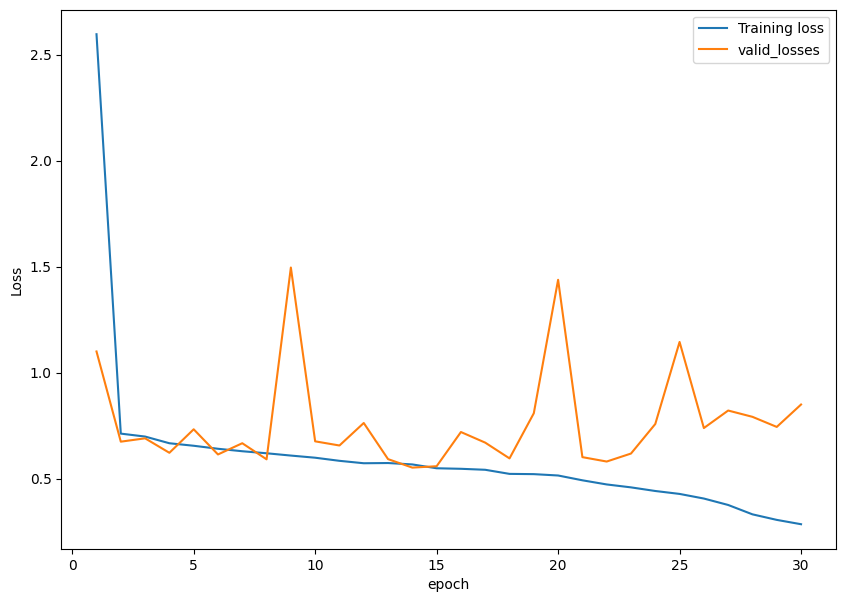

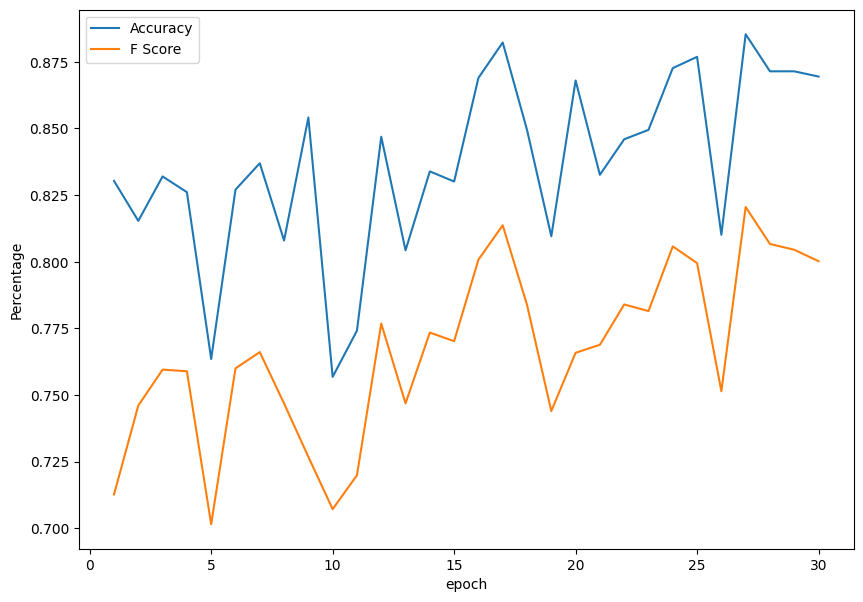

In [91]:
plot_loss(train_losses_tune, valid_losses_tune, 30)
plot_accurate(accuracies_tune, f_scores_tune, 30)

### base_tune prediction accuracy and f1 score

In [92]:
test_loss_tune, accuracy_tune, f_score_tune = test_model(base_tune, test_loader, criterion_tune, test = True, device = device, pt_name ='base_tune.pt', network = Net2())

Test Accuracy: 0.829452 	Test F Score: 0.769279


### Architecture 3: Net3

In [96]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding = 1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.2)

        self.fc1 = nn.Linear(256*8*8, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 1)
        

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 256*8*8)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return x
    

### Build model base_3

In [97]:
base_3 = Net3().to(device)
base_3

Net3(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=16384, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1, bias=True)
)

### base_3 hyperparameters

In [ ]:
optimizer_3 = optim.Adam(base_3.parameters(), lr = 0.008)
pos_weight = torch.tensor([4])
criterion_3 = nn.BCEWithLogitsLoss(pos_weight = pos_weight).to(device)

### Train base_3

In [99]:
train_losses_3, valid_losses_3, accuracies_3, f_scores_3 = train_model(base_3, train_loader, val_loader, 35, optimizer_3, criterion_3, model_name = 'base_3')

Epoch: 1/35, Batch: 235/236: 100%|██████████████████████████████████████████████████| 236/236 [02:03<00:00,  1.91it/s]


Validation starts!
Epoch: 1 	Training Loss: 7.586441 	Validation Loss: 0.739535 	Validation Accuracy: 0.803558 	F_score: 0.725183
Time of Epoch: 2 minutes 27 seconds
Validation loss decreased (inf --> 0.739535). Saving model ...


Epoch: 2/35, Batch: 235/236: 100%|██████████████████████████████████████████████████| 236/236 [03:42<00:00,  1.06it/s]


Validation starts!
Epoch: 2 	Training Loss: 0.737826 	Validation Loss: 0.781779 	Validation Accuracy: 0.824485 	F_score: 0.736487
Time of Epoch: 4 minutes 17 seconds


Epoch: 3/35, Batch: 235/236: 100%|██████████████████████████████████████████████████| 236/236 [25:26<00:00,  6.47s/it]


Validation starts!
Epoch: 3 	Training Loss: 0.687098 	Validation Loss: 0.677764 	Validation Accuracy: 0.790265 	F_score: 0.729021
Time of Epoch: 26 minutes 27 seconds
Validation loss decreased (0.739535 --> 0.677764). Saving model ...


Epoch: 4/35, Batch: 235/236: 100%|██████████████████████████████████████████████████| 236/236 [20:00<00:00,  5.09s/it]


Validation starts!
Epoch: 4 	Training Loss: 0.663516 	Validation Loss: 0.735104 	Validation Accuracy: 0.848124 	F_score: 0.766685
Time of Epoch: 20 minutes 36 seconds


Epoch: 5/35, Batch: 235/236: 100%|██████████████████████████████████████████████████| 236/236 [06:34<00:00,  1.67s/it]


Validation starts!
Epoch: 5 	Training Loss: 0.652575 	Validation Loss: 1.231735 	Validation Accuracy: 0.842815 	F_score: 0.721811
Time of Epoch: 7 minutes 12 seconds


Epoch: 6/35, Batch: 235/236: 100%|██████████████████████████████████████████████████| 236/236 [06:38<00:00,  1.69s/it]


Validation starts!
Epoch: 6 	Training Loss: 0.641720 	Validation Loss: 0.784630 	Validation Accuracy: 0.703844 	F_score: 0.662575
Time of Epoch: 7 minutes 17 seconds


Epoch: 7/35, Batch: 235/236: 100%|██████████████████████████████████████████████████| 236/236 [06:52<00:00,  1.75s/it]


Validation starts!
Epoch: 7 	Training Loss: 0.636496 	Validation Loss: 0.687702 	Validation Accuracy: 0.752054 	F_score: 0.701641
Time of Epoch: 7 minutes 28 seconds


Epoch: 8/35, Batch: 235/236: 100%|██████████████████████████████████████████████████| 236/236 [05:38<00:00,  1.44s/it]


Validation starts!
Epoch: 8 	Training Loss: 0.626477 	Validation Loss: 0.622402 	Validation Accuracy: 0.834522 	F_score: 0.768287
Time of Epoch: 6 minutes 14 seconds
Validation loss decreased (0.677764 --> 0.622402). Saving model ...


Epoch: 9/35, Batch: 235/236: 100%|██████████████████████████████████████████████████| 236/236 [05:32<00:00,  1.41s/it]


Validation starts!
Epoch: 9 	Training Loss: 0.609659 	Validation Loss: 0.596297 	Validation Accuracy: 0.814292 	F_score: 0.752351
Time of Epoch: 6 minutes 8 seconds
Validation loss decreased (0.622402 --> 0.596297). Saving model ...


Epoch: 10/35, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [05:27<00:00,  1.39s/it]


Validation starts!
Epoch: 10 	Training Loss: 0.607578 	Validation Loss: 0.636414 	Validation Accuracy: 0.864013 	F_score: 0.793260
Time of Epoch: 6 minutes 3 seconds


Epoch: 11/35, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [05:18<00:00,  1.35s/it]


Validation starts!
Epoch: 11 	Training Loss: 0.608218 	Validation Loss: 0.602548 	Validation Accuracy: 0.832623 	F_score: 0.766553
Time of Epoch: 5 minutes 42 seconds


Epoch: 12/35, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [05:10<00:00,  1.31s/it]


Validation starts!
Epoch: 12 	Training Loss: 0.591278 	Validation Loss: 0.648984 	Validation Accuracy: 0.828437 	F_score: 0.761026
Time of Epoch: 5 minutes 44 seconds


Epoch: 13/35, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [05:21<00:00,  1.36s/it]


Validation starts!
Epoch: 13 	Training Loss: 0.590247 	Validation Loss: 0.593175 	Validation Accuracy: 0.793598 	F_score: 0.735971
Time of Epoch: 5 minutes 55 seconds
Validation loss decreased (0.596297 --> 0.593175). Saving model ...


Epoch: 14/35, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [05:34<00:00,  1.42s/it]


Validation starts!
Epoch: 14 	Training Loss: 0.590305 	Validation Loss: 0.716104 	Validation Accuracy: 0.864285 	F_score: 0.791498
Time of Epoch: 6 minutes 11 seconds


Epoch: 15/35, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [05:19<00:00,  1.35s/it]


Validation starts!
Epoch: 15 	Training Loss: 0.579670 	Validation Loss: 0.985639 	Validation Accuracy: 0.869051 	F_score: 0.769682
Time of Epoch: 5 minutes 54 seconds


Epoch: 16/35, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [05:08<00:00,  1.31s/it]


Validation starts!
Epoch: 16 	Training Loss: 0.574251 	Validation Loss: 0.622497 	Validation Accuracy: 0.823942 	F_score: 0.759413
Time of Epoch: 5 minutes 39 seconds


Epoch: 17/35, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [05:27<00:00,  1.39s/it]


Validation starts!
Epoch: 17 	Training Loss: 0.567566 	Validation Loss: 0.624093 	Validation Accuracy: 0.848667 	F_score: 0.776538
Time of Epoch: 6 minutes 2 seconds


Epoch: 18/35, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [05:26<00:00,  1.38s/it]


Validation starts!
Epoch: 18 	Training Loss: 0.573225 	Validation Loss: 0.579144 	Validation Accuracy: 0.852503 	F_score: 0.786946
Time of Epoch: 5 minutes 60 seconds
Validation loss decreased (0.593175 --> 0.579144). Saving model ...


Epoch: 19/35, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [05:37<00:00,  1.43s/it]


Validation starts!
Epoch: 19 	Training Loss: 0.565468 	Validation Loss: 1.242613 	Validation Accuracy: 0.851108 	F_score: 0.717625
Time of Epoch: 6 minutes 11 seconds


Epoch: 20/35, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [05:35<00:00,  1.42s/it]


Validation starts!
Epoch: 20 	Training Loss: 0.563735 	Validation Loss: 0.707462 	Validation Accuracy: 0.854945 	F_score: 0.786639
Time of Epoch: 6 minutes 8 seconds


Epoch: 21/35, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [05:33<00:00,  1.41s/it]


Validation starts!
Epoch: 21 	Training Loss: 0.562357 	Validation Loss: 1.454556 	Validation Accuracy: 0.474539 	F_score: 0.534263
Time of Epoch: 6 minutes 5 seconds


Epoch: 22/35, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [21:15<00:00,  5.40s/it]


Validation starts!
Epoch: 22 	Training Loss: 0.550227 	Validation Loss: 0.575707 	Validation Accuracy: 0.832429 	F_score: 0.772349
Time of Epoch: 21 minutes 50 seconds
Validation loss decreased (0.579144 --> 0.575707). Saving model ...


Epoch: 23/35, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [05:36<00:00,  1.42s/it]


Validation starts!
Epoch: 23 	Training Loss: 0.537264 	Validation Loss: 0.580180 	Validation Accuracy: 0.841846 	F_score: 0.779298
Time of Epoch: 5 minutes 59 seconds


Epoch: 24/35, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [05:10<00:00,  1.32s/it]


Validation starts!
Epoch: 24 	Training Loss: 0.531526 	Validation Loss: 0.587387 	Validation Accuracy: 0.805108 	F_score: 0.748109
Time of Epoch: 5 minutes 34 seconds


Epoch: 25/35, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [05:07<00:00,  1.31s/it]


Validation starts!
Epoch: 25 	Training Loss: 0.516587 	Validation Loss: 1.105905 	Validation Accuracy: 0.876143 	F_score: 0.794258
Time of Epoch: 5 minutes 31 seconds


Epoch: 26/35, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [04:47<00:00,  1.22s/it]


Validation starts!
Epoch: 26 	Training Loss: 0.508719 	Validation Loss: 0.639764 	Validation Accuracy: 0.884243 	F_score: 0.816805
Time of Epoch: 5 minutes 10 seconds


Epoch: 27/35, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [04:34<00:00,  1.16s/it]


Validation starts!
Epoch: 27 	Training Loss: 0.506370 	Validation Loss: 1.119153 	Validation Accuracy: 0.866067 	F_score: 0.766518
Time of Epoch: 4 minutes 57 seconds


Epoch: 28/35, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [05:36<00:00,  1.42s/it]


Validation starts!
Epoch: 28 	Training Loss: 0.488276 	Validation Loss: 0.558339 	Validation Accuracy: 0.836731 	F_score: 0.775271
Time of Epoch: 5 minutes 60 seconds
Validation loss decreased (0.575707 --> 0.558339). Saving model ...


Epoch: 29/35, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [05:33<00:00,  1.41s/it]


Validation starts!
Epoch: 29 	Training Loss: 0.474672 	Validation Loss: 0.613757 	Validation Accuracy: 0.843280 	F_score: 0.779330
Time of Epoch: 5 minutes 56 seconds


Epoch: 30/35, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [17:02<00:00,  4.33s/it]


Validation starts!
Epoch: 30 	Training Loss: 0.552047 	Validation Loss: 0.624014 	Validation Accuracy: 0.863083 	F_score: 0.792189
Time of Epoch: 17 minutes 34 seconds


Epoch: 31/35, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [05:17<00:00,  1.35s/it]


Validation starts!
Epoch: 31 	Training Loss: 0.507315 	Validation Loss: 0.705909 	Validation Accuracy: 0.729732 	F_score: 0.684948
Time of Epoch: 5 minutes 41 seconds


Epoch: 32/35, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [04:49<00:00,  1.23s/it]


Validation starts!
Epoch: 32 	Training Loss: 0.484771 	Validation Loss: 0.714873 	Validation Accuracy: 0.754069 	F_score: 0.697838
Time of Epoch: 5 minutes 13 seconds


Epoch: 33/35, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [04:38<00:00,  1.18s/it]


Validation starts!
Epoch: 33 	Training Loss: 0.450120 	Validation Loss: 0.675527 	Validation Accuracy: 0.852348 	F_score: 0.782757
Time of Epoch: 5 minutes 1 seconds


Epoch: 34/35, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [05:08<00:00,  1.31s/it]


Validation starts!
Epoch: 34 	Training Loss: 0.428981 	Validation Loss: 0.641176 	Validation Accuracy: 0.868470 	F_score: 0.802560
Time of Epoch: 5 minutes 42 seconds


Epoch: 35/35, Batch: 235/236: 100%|█████████████████████████████████████████████████| 236/236 [05:07<00:00,  1.30s/it]


Validation starts!
Epoch: 35 	Training Loss: 0.412619 	Validation Loss: 0.827865 	Validation Accuracy: 0.798287 	F_score: 0.732184
Time of Epoch: 5 minutes 30 seconds


### Plot base_3

In [ ]:
plot_loss(train_losses_3, valid_losses_3, 30)
plot_accurate(accuracies_3, f_scores_3, 30)

### base_3 prediction accuracy and f1 score

In [100]:
test_loss_3, accuracy_3, f_score_3 = test_model(base_3, test_loader, criterion_3, test = True, device = device, pt_name ='base_3.pt', network = Net3())

Test Accuracy: 0.833637 	Test F Score: 0.773229


### Reload dataset with batch size at 128

In [101]:
batch_size4 = 128
dataloader4 = DataLoader(dataset, batch_size=batch_size4, shuffle=True)

# Split the dataset
torch.manual_seed(1)
train_dataset4, val_dataset4, test_dataset4 = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders for each set
train_loader4 = DataLoader(train_dataset4, batch_size=batch_size4, shuffle=True)
val_loader4 = DataLoader(val_dataset4, batch_size=batch_size4, shuffle=False)
test_loader4 = DataLoader(test_dataset4, batch_size=batch_size4, shuffle=False)
input_try, label_try = next(iter(train_loader4))
print('Batch of images:', input_try.size())
print('Batch of labels:', label_try.size())


Batch of images: torch.Size([128, 3, 64, 64])
Batch of labels: torch.Size([128, 1])


### Build model base_4

In [102]:
base_4 = Net3().to(device)
base_4

Net3(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=16384, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1, bias=True)
)

### base_4 hyperparameters

In [103]:
optimizer4 = optim.Adam(base_4.parameters(), lr = 0.008)

### Train base_4 on dataloader with batch size at 128

In [105]:
train_losses_4, valid_losses_4, accuracies_4, f_scores_4 = train_model(base_4, train_loader4, val_loader4, 35, optimizer4, criterion_3, model_name = 'base_4')

Epoch: 1/35, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [03:59<00:00,  3.93it/s]


Validation starts!
Epoch: 1 	Training Loss: 2.163788 	Validation Loss: 0.791956 	Validation Accuracy: 0.812548 	F_score: 0.722442
Time of Epoch: 4 minutes 41 seconds
Validation loss decreased (inf --> 0.791956). Saving model ...


Epoch: 2/35, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [03:33<00:00,  4.40it/s]


Validation starts!
Epoch: 2 	Training Loss: 0.720300 	Validation Loss: 0.684471 	Validation Accuracy: 0.792242 	F_score: 0.728818
Time of Epoch: 4 minutes 1 seconds
Validation loss decreased (0.791956 --> 0.684471). Saving model ...


Epoch: 3/35, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [03:01<00:00,  5.18it/s]


Validation starts!
Epoch: 3 	Training Loss: 0.711848 	Validation Loss: 0.633885 	Validation Accuracy: 0.829213 	F_score: 0.761410
Time of Epoch: 3 minutes 29 seconds
Validation loss decreased (0.684471 --> 0.633885). Saving model ...


Epoch: 4/35, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [03:02<00:00,  5.16it/s]


Validation starts!
Epoch: 4 	Training Loss: 0.810504 	Validation Loss: 0.916428 	Validation Accuracy: 0.849403 	F_score: 0.762586
Time of Epoch: 3 minutes 31 seconds


Epoch: 5/35, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [03:32<00:00,  4.43it/s]


Validation starts!
Epoch: 5 	Training Loss: 0.838763 	Validation Loss: 0.756802 	Validation Accuracy: 0.862773 	F_score: 0.773115
Time of Epoch: 4 minutes 13 seconds


Epoch: 6/35, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [03:33<00:00,  4.40it/s]


Validation starts!
Epoch: 6 	Training Loss: 0.764178 	Validation Loss: 0.650472 	Validation Accuracy: 0.814370 	F_score: 0.748978
Time of Epoch: 4 minutes 13 seconds


Epoch: 7/35, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [04:03<00:00,  3.87it/s]


Validation starts!
Epoch: 7 	Training Loss: 0.711984 	Validation Loss: 0.604922 	Validation Accuracy: 0.836343 	F_score: 0.770377
Time of Epoch: 4 minutes 48 seconds
Validation loss decreased (0.633885 --> 0.604922). Saving model ...


Epoch: 8/35, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [10:42<00:00,  1.46it/s]


Validation starts!
Epoch: 8 	Training Loss: 0.672482 	Validation Loss: 0.611363 	Validation Accuracy: 0.819563 	F_score: 0.755565
Time of Epoch: 11 minutes 31 seconds


Epoch: 9/35, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [08:24<00:00,  1.87it/s]


Validation starts!
Epoch: 9 	Training Loss: 0.651781 	Validation Loss: 0.633193 	Validation Accuracy: 0.792125 	F_score: 0.730858
Time of Epoch: 9 minutes 4 seconds


Epoch: 10/35, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [03:47<00:00,  4.13it/s]


Validation starts!
Epoch: 10 	Training Loss: 0.641977 	Validation Loss: 0.592034 	Validation Accuracy: 0.842583 	F_score: 0.777547
Time of Epoch: 4 minutes 29 seconds
Validation loss decreased (0.604922 --> 0.592034). Saving model ...


Epoch: 11/35, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [03:26<00:00,  4.57it/s]


Validation starts!
Epoch: 11 	Training Loss: 0.637840 	Validation Loss: 0.732390 	Validation Accuracy: 0.870175 	F_score: 0.781702
Time of Epoch: 3 minutes 52 seconds


Epoch: 12/35, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:59<00:00,  5.23it/s]


Validation starts!
Epoch: 12 	Training Loss: 0.689822 	Validation Loss: 0.625698 	Validation Accuracy: 0.832235 	F_score: 0.766089
Time of Epoch: 3 minutes 26 seconds


Epoch: 13/35, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [03:00<00:00,  5.20it/s]


Validation starts!
Epoch: 13 	Training Loss: 0.669480 	Validation Loss: 0.674201 	Validation Accuracy: 0.856611 	F_score: 0.781065
Time of Epoch: 3 minutes 27 seconds


Epoch: 14/35, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:59<00:00,  5.23it/s]


Validation starts!
Epoch: 14 	Training Loss: 0.637012 	Validation Loss: 0.629408 	Validation Accuracy: 0.789102 	F_score: 0.731577
Time of Epoch: 3 minutes 25 seconds


Epoch: 15/35, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:59<00:00,  5.24it/s]


Validation starts!
Epoch: 15 	Training Loss: 0.642154 	Validation Loss: 0.595422 	Validation Accuracy: 0.803054 	F_score: 0.743281
Time of Epoch: 3 minutes 27 seconds


Epoch: 16/35, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:59<00:00,  5.26it/s]


Validation starts!
Epoch: 16 	Training Loss: 1.175229 	Validation Loss: 0.642269 	Validation Accuracy: 0.838010 	F_score: 0.768959
Time of Epoch: 3 minutes 24 seconds


Epoch: 17/35, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:59<00:00,  5.26it/s]


Validation starts!
Epoch: 17 	Training Loss: 0.682255 	Validation Loss: 0.604644 	Validation Accuracy: 0.809797 	F_score: 0.748746
Time of Epoch: 3 minutes 25 seconds


Epoch: 18/35, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:58<00:00,  5.26it/s]


Validation starts!
Epoch: 18 	Training Loss: 0.659896 	Validation Loss: 0.652135 	Validation Accuracy: 0.828244 	F_score: 0.763197
Time of Epoch: 3 minutes 25 seconds


Epoch: 19/35, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:59<00:00,  5.25it/s]


Validation starts!
Epoch: 19 	Training Loss: 0.639120 	Validation Loss: 0.659097 	Validation Accuracy: 0.861068 	F_score: 0.792379
Time of Epoch: 3 minutes 25 seconds


Epoch: 20/35, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:59<00:00,  5.24it/s]


Validation starts!
Epoch: 20 	Training Loss: 0.630854 	Validation Loss: 0.573744 	Validation Accuracy: 0.844947 	F_score: 0.780201
Time of Epoch: 3 minutes 26 seconds
Validation loss decreased (0.592034 --> 0.573744). Saving model ...


Epoch: 21/35, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:59<00:00,  5.26it/s]


Validation starts!
Epoch: 21 	Training Loss: 0.920026 	Validation Loss: 0.879531 	Validation Accuracy: 0.821888 	F_score: 0.743154
Time of Epoch: 3 minutes 25 seconds


Epoch: 22/35, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [03:49<00:00,  4.11it/s]


Validation starts!
Epoch: 22 	Training Loss: 0.806163 	Validation Loss: 0.658090 	Validation Accuracy: 0.801039 	F_score: 0.739100
Time of Epoch: 4 minutes 27 seconds


Epoch: 23/35, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [03:35<00:00,  4.37it/s]


Validation starts!
Epoch: 23 	Training Loss: 0.725795 	Validation Loss: 0.742971 	Validation Accuracy: 0.777166 	F_score: 0.719731
Time of Epoch: 4 minutes 15 seconds


Epoch: 24/35, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [04:21<00:00,  3.59it/s]


Validation starts!
Epoch: 24 	Training Loss: 0.698125 	Validation Loss: 0.636166 	Validation Accuracy: 0.781933 	F_score: 0.724531
Time of Epoch: 5 minutes 4 seconds


Epoch: 25/35, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [04:04<00:00,  3.85it/s]


Validation starts!
Epoch: 25 	Training Loss: 0.692027 	Validation Loss: 0.643951 	Validation Accuracy: 0.819253 	F_score: 0.752442
Time of Epoch: 4 minutes 37 seconds


Epoch: 26/35, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [03:52<00:00,  4.05it/s]


Validation starts!
Epoch: 26 	Training Loss: 0.661584 	Validation Loss: 0.612610 	Validation Accuracy: 0.843203 	F_score: 0.778955
Time of Epoch: 5 minutes 59 seconds


Epoch: 27/35, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [18:49<00:00,  1.20s/it]


Validation starts!
Epoch: 27 	Training Loss: 0.640822 	Validation Loss: 0.652911 	Validation Accuracy: 0.770578 	F_score: 0.713234
Time of Epoch: 19 minutes 20 seconds


Epoch: 28/35, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [03:16<00:00,  4.78it/s]


Validation starts!
Epoch: 28 	Training Loss: 0.692027 	Validation Loss: 0.626573 	Validation Accuracy: 0.758487 	F_score: 0.707225
Time of Epoch: 3 minutes 43 seconds


Epoch: 29/35, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [03:14<00:00,  4.84it/s]


Validation starts!
Epoch: 29 	Training Loss: 0.645333 	Validation Loss: 0.596206 	Validation Accuracy: 0.800922 	F_score: 0.741872
Time of Epoch: 3 minutes 41 seconds


Epoch: 30/35, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [03:15<00:00,  4.82it/s]


Validation starts!
Epoch: 30 	Training Loss: 0.649590 	Validation Loss: 0.577658 	Validation Accuracy: 0.827895 	F_score: 0.765609
Time of Epoch: 3 minutes 42 seconds


Epoch: 31/35, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [03:07<00:00,  5.03it/s]


Validation starts!
Epoch: 31 	Training Loss: 0.652421 	Validation Loss: 0.597850 	Validation Accuracy: 0.809099 	F_score: 0.749006
Time of Epoch: 3 minutes 34 seconds


Epoch: 32/35, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [03:17<00:00,  4.77it/s]


Validation starts!
Epoch: 32 	Training Loss: 0.678392 	Validation Loss: 0.584992 	Validation Accuracy: 0.835336 	F_score: 0.771743
Time of Epoch: 3 minutes 44 seconds


Epoch: 33/35, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [03:12<00:00,  4.88it/s]


Validation starts!
Epoch: 33 	Training Loss: 0.657074 	Validation Loss: 0.664076 	Validation Accuracy: 0.854402 	F_score: 0.774639
Time of Epoch: 3 minutes 39 seconds


Epoch: 34/35, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [03:14<00:00,  4.84it/s]


Validation starts!
Epoch: 34 	Training Loss: 0.639434 	Validation Loss: 0.582957 	Validation Accuracy: 0.822392 	F_score: 0.762157
Time of Epoch: 3 minutes 42 seconds


Epoch: 35/35, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [03:34<00:00,  4.38it/s]


Validation starts!
Epoch: 35 	Training Loss: 0.630026 	Validation Loss: 0.663261 	Validation Accuracy: 0.754263 	F_score: 0.699151
Time of Epoch: 4 minutes 0 seconds


### Plot base_4

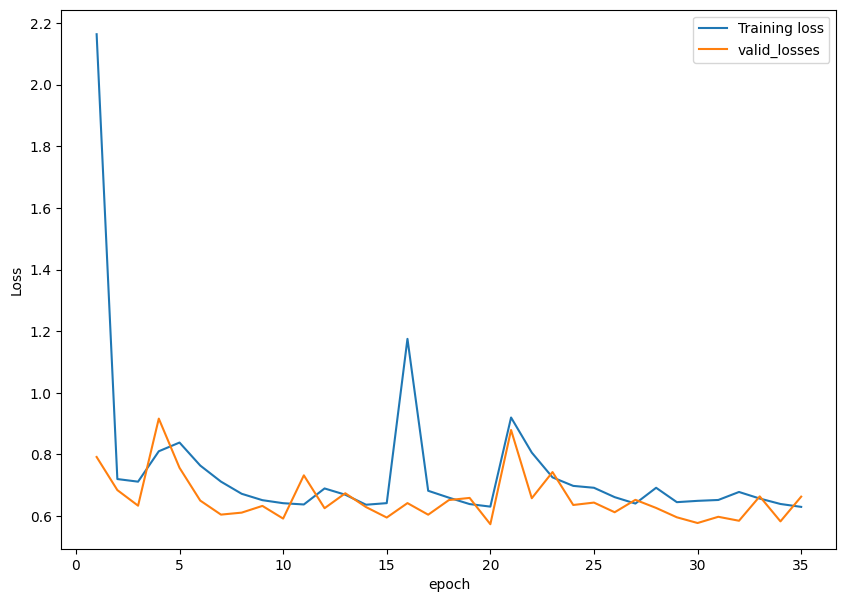

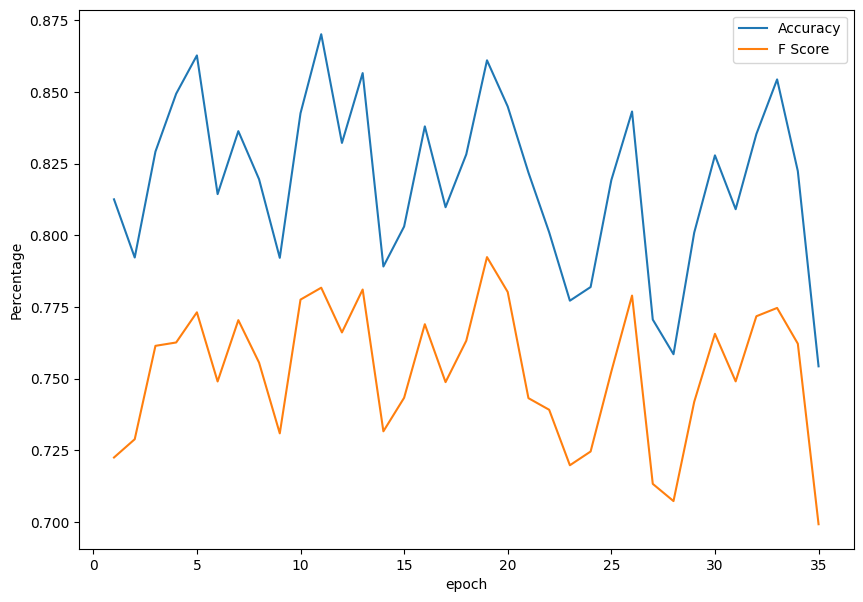

In [106]:
plot_loss(train_losses_4, valid_losses_4, 35)
plot_accurate(accuracies_4, f_scores_4, 35)

### base_4 prediction accuracy and f1 score

In [109]:
test_loss_4, accuracy_4, f_score_4 = test_model(base_4, test_loader4, criterion_3, test = True, device = device, pt_name ='base_4.pt', network = Net3())

Test Accuracy: 0.842240 	Test F Score: 0.777432


### Build model base_5

In [112]:
base_5 = Net3().to(device)
optimizer5 = optim.Adam(base_5.parameters(), lr = 0.003)
criterion5 = criterion_3

### Train base_5 on 128 batch size dataloader

Epoch: 1/50, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [03:01<00:00,  5.19it/s]


Validation starts!
Epoch: 1 	Training Loss: 1.084995 	Validation Loss: 0.801628 	Validation Accuracy: 0.798287 	F_score: 0.719815
Time of Epoch: 3 minutes 39 seconds
Validation loss decreased (inf --> 0.801628). Saving model ...


Epoch: 2/50, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:38<00:00,  5.94it/s]


Validation starts!
Epoch: 2 	Training Loss: 0.709173 	Validation Loss: 0.691032 	Validation Accuracy: 0.815261 	F_score: 0.748377
Time of Epoch: 3 minutes 4 seconds
Validation loss decreased (0.801628 --> 0.691032). Saving model ...


Epoch: 3/50, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:39<00:00,  5.92it/s]


Validation starts!
Epoch: 3 	Training Loss: 0.674132 	Validation Loss: 0.673285 	Validation Accuracy: 0.820260 	F_score: 0.754603
Time of Epoch: 3 minutes 5 seconds
Validation loss decreased (0.691032 --> 0.673285). Saving model ...


Epoch: 4/50, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:39<00:00,  5.90it/s]


Validation starts!
Epoch: 4 	Training Loss: 0.655100 	Validation Loss: 0.675644 	Validation Accuracy: 0.853046 	F_score: 0.781340
Time of Epoch: 3 minutes 5 seconds


Epoch: 5/50, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:39<00:00,  5.89it/s]


Validation starts!
Epoch: 5 	Training Loss: 0.637002 	Validation Loss: 0.632181 	Validation Accuracy: 0.820183 	F_score: 0.756558
Time of Epoch: 3 minutes 6 seconds
Validation loss decreased (0.673285 --> 0.632181). Saving model ...


Epoch: 6/50, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:39<00:00,  5.89it/s]


Validation starts!
Epoch: 6 	Training Loss: 0.624397 	Validation Loss: 0.677428 	Validation Accuracy: 0.872035 	F_score: 0.795744
Time of Epoch: 3 minutes 6 seconds


Epoch: 7/50, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:39<00:00,  5.89it/s]


Validation starts!
Epoch: 7 	Training Loss: 0.612252 	Validation Loss: 0.604751 	Validation Accuracy: 0.857890 	F_score: 0.788877
Time of Epoch: 3 minutes 6 seconds
Validation loss decreased (0.632181 --> 0.604751). Saving model ...


Epoch: 8/50, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:39<00:00,  5.91it/s]


Validation starts!
Epoch: 8 	Training Loss: 0.650257 	Validation Loss: 0.631775 	Validation Accuracy: 0.780422 	F_score: 0.724175
Time of Epoch: 3 minutes 5 seconds


Epoch: 9/50, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:38<00:00,  5.94it/s]


Validation starts!
Epoch: 9 	Training Loss: 0.593284 	Validation Loss: 0.591972 	Validation Accuracy: 0.863044 	F_score: 0.793864
Time of Epoch: 3 minutes 5 seconds
Validation loss decreased (0.604751 --> 0.591972). Saving model ...


Epoch: 10/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:38<00:00,  5.93it/s]


Validation starts!
Epoch: 10 	Training Loss: 0.557838 	Validation Loss: 0.570133 	Validation Accuracy: 0.874206 	F_score: 0.810464
Time of Epoch: 3 minutes 5 seconds
Validation loss decreased (0.591972 --> 0.570133). Saving model ...


Epoch: 11/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:35<00:00,  6.03it/s]


Validation starts!
Epoch: 11 	Training Loss: 0.531080 	Validation Loss: 0.592702 	Validation Accuracy: 0.852852 	F_score: 0.788668
Time of Epoch: 3 minutes 2 seconds


Epoch: 12/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:39<00:00,  5.91it/s]


Validation starts!
Epoch: 12 	Training Loss: 0.516384 	Validation Loss: 0.567534 	Validation Accuracy: 0.856921 	F_score: 0.795796
Time of Epoch: 3 minutes 5 seconds
Validation loss decreased (0.570133 --> 0.567534). Saving model ...


Epoch: 13/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:40<00:00,  5.88it/s]


Validation starts!
Epoch: 13 	Training Loss: 0.495392 	Validation Loss: 0.517254 	Validation Accuracy: 0.850101 	F_score: 0.790693
Time of Epoch: 3 minutes 6 seconds
Validation loss decreased (0.567534 --> 0.517254). Saving model ...


Epoch: 14/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:39<00:00,  5.89it/s]


Validation starts!
Epoch: 14 	Training Loss: 0.468793 	Validation Loss: 0.620371 	Validation Accuracy: 0.857503 	F_score: 0.795688
Time of Epoch: 3 minutes 6 seconds


Epoch: 15/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:39<00:00,  5.91it/s]


Validation starts!
Epoch: 15 	Training Loss: 0.440437 	Validation Loss: 0.577881 	Validation Accuracy: 0.824833 	F_score: 0.766094
Time of Epoch: 3 minutes 5 seconds


Epoch: 16/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:39<00:00,  5.91it/s]


Validation starts!
Epoch: 16 	Training Loss: 0.414478 	Validation Loss: 0.568333 	Validation Accuracy: 0.860293 	F_score: 0.800067
Time of Epoch: 3 minutes 5 seconds


Epoch: 17/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:38<00:00,  5.94it/s]


Validation starts!
Epoch: 17 	Training Loss: 0.382258 	Validation Loss: 0.574171 	Validation Accuracy: 0.860293 	F_score: 0.798502
Time of Epoch: 3 minutes 4 seconds


Epoch: 18/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:38<00:00,  5.94it/s]


Validation starts!
Epoch: 18 	Training Loss: 0.346910 	Validation Loss: 0.702789 	Validation Accuracy: 0.879902 	F_score: 0.819163
Time of Epoch: 3 minutes 4 seconds


Epoch: 19/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:38<00:00,  5.92it/s]


Validation starts!
Epoch: 19 	Training Loss: 0.330725 	Validation Loss: 0.637769 	Validation Accuracy: 0.843125 	F_score: 0.782926
Time of Epoch: 3 minutes 5 seconds


Epoch: 20/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:39<00:00,  5.90it/s]


Validation starts!
Epoch: 20 	Training Loss: 0.310591 	Validation Loss: 0.760876 	Validation Accuracy: 0.864905 	F_score: 0.804399
Time of Epoch: 3 minutes 5 seconds


Epoch: 21/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:47<00:00,  5.62it/s]


Validation starts!
Epoch: 21 	Training Loss: 0.297575 	Validation Loss: 0.837691 	Validation Accuracy: 0.877190 	F_score: 0.813071
Time of Epoch: 3 minutes 15 seconds


Epoch: 22/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:38<00:00,  5.92it/s]


Validation starts!
Epoch: 22 	Training Loss: 0.261127 	Validation Loss: 0.953375 	Validation Accuracy: 0.887924 	F_score: 0.824642
Time of Epoch: 3 minutes 5 seconds


Epoch: 23/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:38<00:00,  5.95it/s]


Validation starts!
Epoch: 23 	Training Loss: 0.255410 	Validation Loss: 0.787123 	Validation Accuracy: 0.834871 	F_score: 0.773772
Time of Epoch: 3 minutes 4 seconds


Epoch: 24/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:48<00:00,  5.57it/s]


Validation starts!
Epoch: 24 	Training Loss: 0.236102 	Validation Loss: 0.714181 	Validation Accuracy: 0.841265 	F_score: 0.780752
Time of Epoch: 3 minutes 15 seconds


Epoch: 25/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:40<00:00,  5.88it/s]


Validation starts!
Epoch: 25 	Training Loss: 0.230107 	Validation Loss: 0.784118 	Validation Accuracy: 0.864440 	F_score: 0.797452
Time of Epoch: 3 minutes 6 seconds


Epoch: 26/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:38<00:00,  5.94it/s]


Validation starts!
Epoch: 26 	Training Loss: 0.210753 	Validation Loss: 0.848982 	Validation Accuracy: 0.861998 	F_score: 0.798802
Time of Epoch: 3 minutes 5 seconds


Epoch: 27/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:37<00:00,  5.96it/s]


Validation starts!
Epoch: 27 	Training Loss: 0.210578 	Validation Loss: 1.255368 	Validation Accuracy: 0.880174 	F_score: 0.804304
Time of Epoch: 3 minutes 3 seconds


Epoch: 28/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:38<00:00,  5.92it/s]


Validation starts!
Epoch: 28 	Training Loss: 0.190091 	Validation Loss: 1.322953 	Validation Accuracy: 0.884437 	F_score: 0.815744
Time of Epoch: 3 minutes 5 seconds


Epoch: 29/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:39<00:00,  5.91it/s]


Validation starts!
Epoch: 29 	Training Loss: 0.194693 	Validation Loss: 1.047041 	Validation Accuracy: 0.882654 	F_score: 0.816862
Time of Epoch: 3 minutes 5 seconds


Epoch: 30/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:40<00:00,  5.87it/s]


Validation starts!
Epoch: 30 	Training Loss: 0.177634 	Validation Loss: 0.947623 	Validation Accuracy: 0.880639 	F_score: 0.815635
Time of Epoch: 3 minutes 6 seconds


Epoch: 31/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:37<00:00,  5.96it/s]


Validation starts!
Epoch: 31 	Training Loss: 0.179246 	Validation Loss: 1.414507 	Validation Accuracy: 0.887537 	F_score: 0.813376
Time of Epoch: 3 minutes 4 seconds


Epoch: 32/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:37<00:00,  5.96it/s]


Validation starts!
Epoch: 32 	Training Loss: 0.168213 	Validation Loss: 1.252151 	Validation Accuracy: 0.877500 	F_score: 0.806560
Time of Epoch: 3 minutes 4 seconds


Epoch: 33/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:39<00:00,  5.89it/s]


Validation starts!
Epoch: 33 	Training Loss: 0.154184 	Validation Loss: 0.955004 	Validation Accuracy: 0.883933 	F_score: 0.817144
Time of Epoch: 3 minutes 6 seconds


Epoch: 34/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:41<00:00,  5.81it/s]


Validation starts!
Epoch: 34 	Training Loss: 0.174011 	Validation Loss: 1.048878 	Validation Accuracy: 0.884514 	F_score: 0.810288
Time of Epoch: 3 minutes 8 seconds


Epoch: 35/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:47<00:00,  5.63it/s]


Validation starts!
Epoch: 35 	Training Loss: 0.161983 	Validation Loss: 0.905029 	Validation Accuracy: 0.871415 	F_score: 0.803133
Time of Epoch: 3 minutes 27 seconds


Epoch: 36/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:46<00:00,  5.66it/s]


Validation starts!
Epoch: 36 	Training Loss: 0.155744 	Validation Loss: 1.017836 	Validation Accuracy: 0.873741 	F_score: 0.803759
Time of Epoch: 3 minutes 13 seconds


Epoch: 37/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:35<00:00,  6.06it/s]


Validation starts!
Epoch: 37 	Training Loss: 0.143120 	Validation Loss: 1.159523 	Validation Accuracy: 0.883429 	F_score: 0.816227
Time of Epoch: 3 minutes 2 seconds


Epoch: 38/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [03:09<00:00,  4.97it/s]


Validation starts!
Epoch: 38 	Training Loss: 0.130752 	Validation Loss: 1.367967 	Validation Accuracy: 0.885212 	F_score: 0.814713
Time of Epoch: 3 minutes 49 seconds


Epoch: 39/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [03:11<00:00,  4.92it/s]


Validation starts!
Epoch: 39 	Training Loss: 0.135203 	Validation Loss: 1.326321 	Validation Accuracy: 0.877190 	F_score: 0.800780
Time of Epoch: 3 minutes 38 seconds


Epoch: 40/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:25<00:00,  6.46it/s]


Validation starts!
Epoch: 40 	Training Loss: 0.164915 	Validation Loss: 1.226079 	Validation Accuracy: 0.889978 	F_score: 0.813995
Time of Epoch: 2 minutes 56 seconds


Epoch: 41/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [03:10<00:00,  4.94it/s]


Validation starts!
Epoch: 41 	Training Loss: 0.113963 	Validation Loss: 1.408685 	Validation Accuracy: 0.889707 	F_score: 0.812886
Time of Epoch: 3 minutes 49 seconds


Epoch: 42/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:42<00:00,  5.78it/s]


Validation starts!
Epoch: 42 	Training Loss: 0.135128 	Validation Loss: 1.131644 	Validation Accuracy: 0.884282 	F_score: 0.816517
Time of Epoch: 3 minutes 9 seconds


Epoch: 43/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:28<00:00,  6.34it/s]


Validation starts!
Epoch: 43 	Training Loss: 0.109529 	Validation Loss: 1.378908 	Validation Accuracy: 0.876686 	F_score: 0.786929
Time of Epoch: 2 minutes 55 seconds


Epoch: 44/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:27<00:00,  6.38it/s]


Validation starts!
Epoch: 44 	Training Loss: 0.134159 	Validation Loss: 1.278774 	Validation Accuracy: 0.889707 	F_score: 0.815243
Time of Epoch: 2 minutes 54 seconds


Epoch: 45/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:28<00:00,  6.33it/s]


Validation starts!
Epoch: 45 	Training Loss: 0.109489 	Validation Loss: 1.136334 	Validation Accuracy: 0.884863 	F_score: 0.816026
Time of Epoch: 2 minutes 55 seconds


Epoch: 46/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:27<00:00,  6.37it/s]


Validation starts!
Epoch: 46 	Training Loss: 0.139619 	Validation Loss: 1.239132 	Validation Accuracy: 0.885909 	F_score: 0.809844
Time of Epoch: 2 minutes 54 seconds


Epoch: 47/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:28<00:00,  6.35it/s]


Validation starts!
Epoch: 47 	Training Loss: 0.106739 	Validation Loss: 1.349092 	Validation Accuracy: 0.889126 	F_score: 0.812725
Time of Epoch: 2 minutes 54 seconds


Epoch: 48/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:28<00:00,  6.33it/s]


Validation starts!
Epoch: 48 	Training Loss: 0.114652 	Validation Loss: 1.415182 	Validation Accuracy: 0.886025 	F_score: 0.805939
Time of Epoch: 2 minutes 56 seconds


Epoch: 49/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:27<00:00,  6.37it/s]


Validation starts!
Epoch: 49 	Training Loss: 0.109390 	Validation Loss: 0.917558 	Validation Accuracy: 0.868780 	F_score: 0.802681
Time of Epoch: 2 minutes 55 seconds


Epoch: 50/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:28<00:00,  6.35it/s]


Validation starts!
Epoch: 50 	Training Loss: 0.126081 	Validation Loss: 1.048159 	Validation Accuracy: 0.881414 	F_score: 0.813324
Time of Epoch: 2 minutes 55 seconds


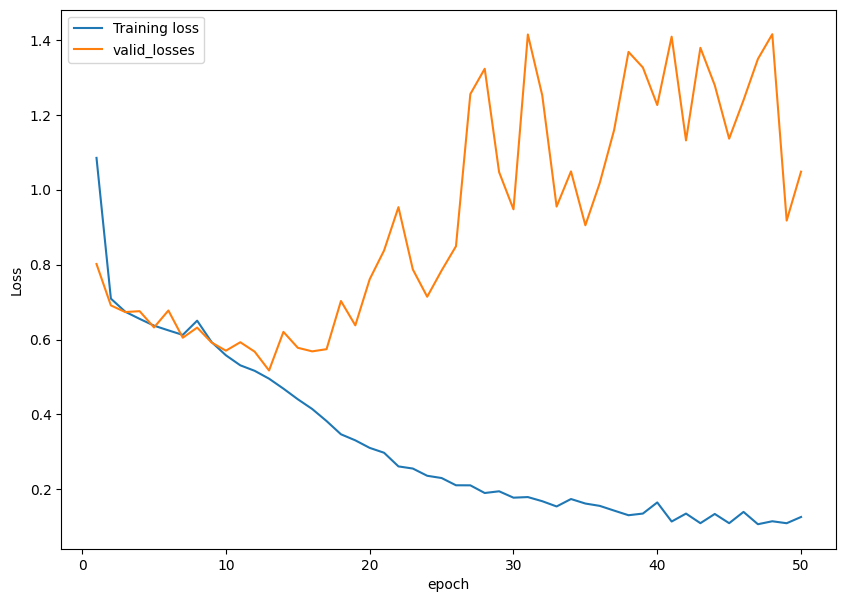

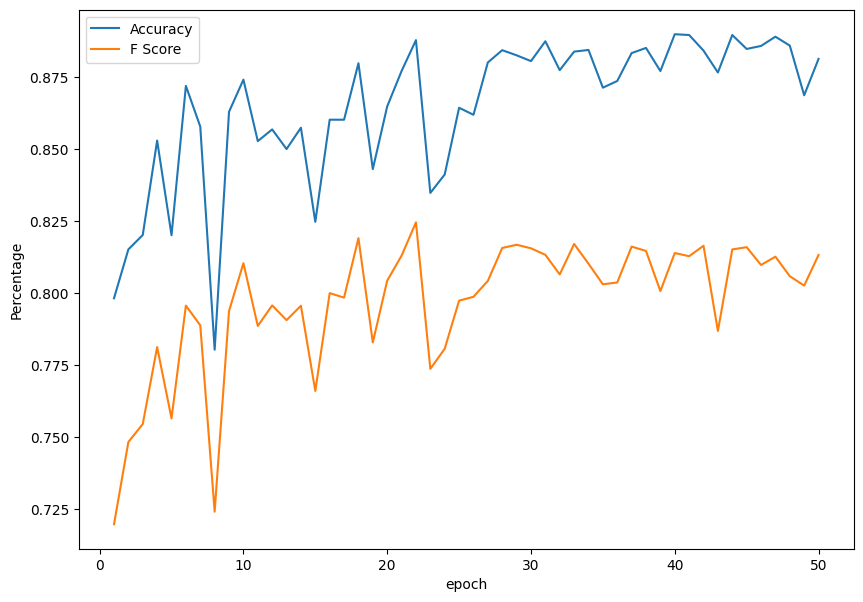

In [113]:
train_losses_5, valid_losses_5, accuracies_5, f_scores_5 = train_model(base_5, train_loader4, val_loader4, 50, optimizer5, criterion5, model_name = 'base_5')

### Plot base_5

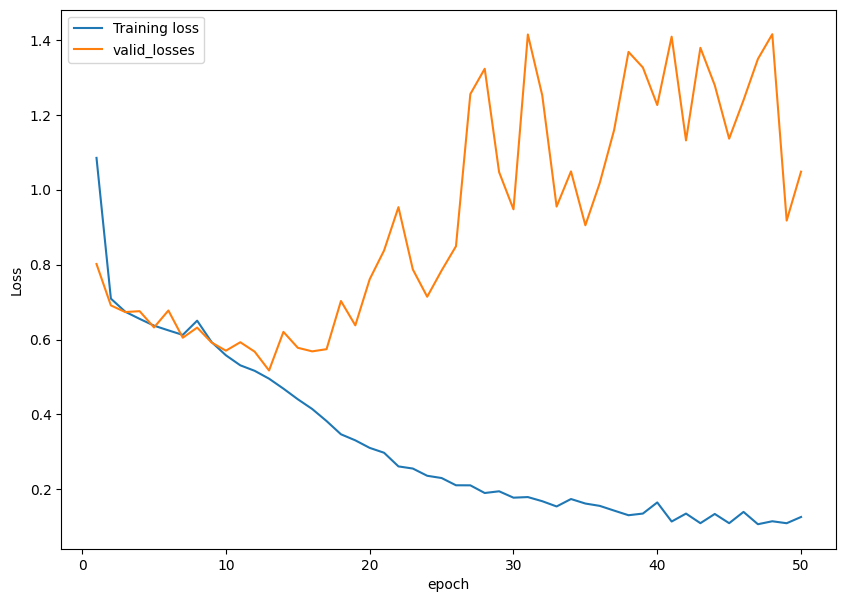

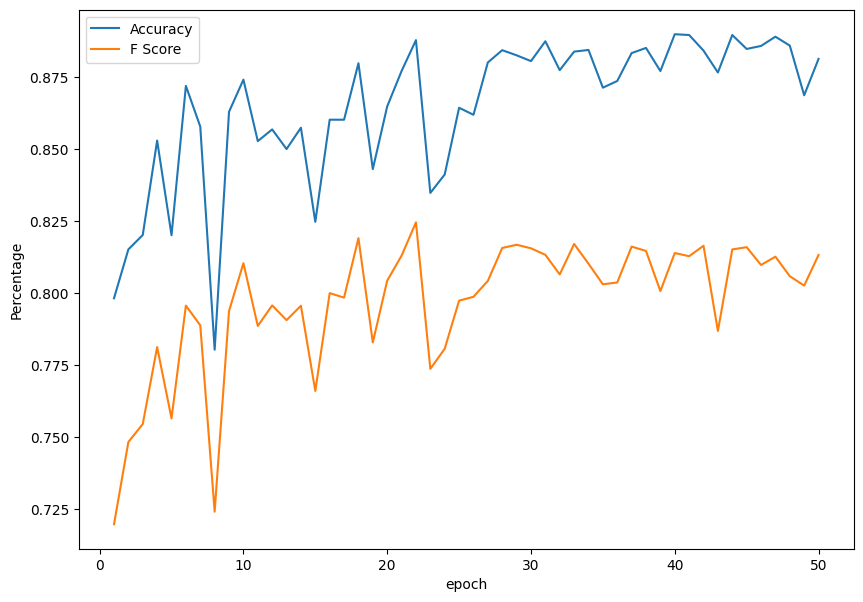

In [115]:
plot_loss(train_losses_5, valid_losses_5, 50)
plot_accurate(accuracies_5, f_scores_5, 50)

### base_5 prediction accuracy and f1 score

In [114]:
test_loss_5, accuracy_5, f_score_5 = test_model(base_5, test_loader4, criterion5, test = True, device = device, pt_name ='base_5.pt', network = Net3())

Test Accuracy: 0.847510 	Test F Score: 0.789876


### Build model base_6

In [119]:
base_6 = Net().to(device)
optimizer6 = optim.Adam(base_6.parameters(), lr = 0.002)
criterion6 = criterion

### Train base_6

In [120]:
train_losses_6, valid_losses_6, accuracies_6, f_scores_6 = train_model(base_6, train_loader4, val_loader4, 50, optimizer6, criterion6, model_name = 'base_6')

Epoch: 1/50, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:21<00:00,  6.64it/s]


Validation starts!
Epoch: 1 	Training Loss: 0.718181 	Validation Loss: 1.197960 	Validation Accuracy: 0.845063 	F_score: 0.709490
Time of Epoch: 2 minutes 58 seconds
Validation loss decreased (inf --> 1.197960). Saving model ...


Epoch: 2/50, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:08<00:00,  7.31it/s]


Validation starts!
Epoch: 2 	Training Loss: 0.639858 	Validation Loss: 0.612569 	Validation Accuracy: 0.848861 	F_score: 0.780726
Time of Epoch: 2 minutes 35 seconds
Validation loss decreased (1.197960 --> 0.612569). Saving model ...


Epoch: 3/50, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:07<00:00,  7.35it/s]


Validation starts!
Epoch: 3 	Training Loss: 0.616740 	Validation Loss: 0.610551 	Validation Accuracy: 0.831228 	F_score: 0.767274
Time of Epoch: 2 minutes 34 seconds
Validation loss decreased (0.612569 --> 0.610551). Saving model ...


Epoch: 4/50, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:07<00:00,  7.36it/s]


Validation starts!
Epoch: 4 	Training Loss: 0.595132 	Validation Loss: 0.593167 	Validation Accuracy: 0.832429 	F_score: 0.770098
Time of Epoch: 2 minutes 34 seconds
Validation loss decreased (0.610551 --> 0.593167). Saving model ...


Epoch: 5/50, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:08<00:00,  7.34it/s]


Validation starts!
Epoch: 5 	Training Loss: 0.575775 	Validation Loss: 0.589325 	Validation Accuracy: 0.850566 	F_score: 0.783857
Time of Epoch: 2 minutes 34 seconds
Validation loss decreased (0.593167 --> 0.589325). Saving model ...


Epoch: 6/50, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:07<00:00,  7.36it/s]


Validation starts!
Epoch: 6 	Training Loss: 0.557779 	Validation Loss: 0.575917 	Validation Accuracy: 0.869710 	F_score: 0.804807
Time of Epoch: 2 minutes 34 seconds
Validation loss decreased (0.589325 --> 0.575917). Saving model ...


Epoch: 7/50, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:06<00:00,  7.45it/s]


Validation starts!
Epoch: 7 	Training Loss: 0.543073 	Validation Loss: 0.569705 	Validation Accuracy: 0.846923 	F_score: 0.783893
Time of Epoch: 2 minutes 32 seconds
Validation loss decreased (0.575917 --> 0.569705). Saving model ...


Epoch: 8/50, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:07<00:00,  7.38it/s]


Validation starts!
Epoch: 8 	Training Loss: 0.523033 	Validation Loss: 0.587270 	Validation Accuracy: 0.821966 	F_score: 0.761574
Time of Epoch: 2 minutes 33 seconds


Epoch: 9/50, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:07<00:00,  7.40it/s]


Validation starts!
Epoch: 9 	Training Loss: 0.504659 	Validation Loss: 0.541240 	Validation Accuracy: 0.843396 	F_score: 0.783614
Time of Epoch: 2 minutes 33 seconds
Validation loss decreased (0.569705 --> 0.541240). Saving model ...


Epoch: 10/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:07<00:00,  7.39it/s]


Validation starts!
Epoch: 10 	Training Loss: 0.491979 	Validation Loss: 0.554000 	Validation Accuracy: 0.847659 	F_score: 0.785601
Time of Epoch: 2 minutes 34 seconds


Epoch: 11/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:08<00:00,  7.34it/s]


Validation starts!
Epoch: 11 	Training Loss: 0.474263 	Validation Loss: 0.560803 	Validation Accuracy: 0.833863 	F_score: 0.774404
Time of Epoch: 2 minutes 34 seconds


Epoch: 12/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:08<00:00,  7.34it/s]


Validation starts!
Epoch: 12 	Training Loss: 0.454996 	Validation Loss: 0.544625 	Validation Accuracy: 0.865098 	F_score: 0.804669
Time of Epoch: 2 minutes 34 seconds


Epoch: 13/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:07<00:00,  7.36it/s]


Validation starts!
Epoch: 13 	Training Loss: 0.434534 	Validation Loss: 0.535624 	Validation Accuracy: 0.859828 	F_score: 0.800617
Time of Epoch: 2 minutes 33 seconds
Validation loss decreased (0.541240 --> 0.535624). Saving model ...


Epoch: 14/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:08<00:00,  7.34it/s]


Validation starts!
Epoch: 14 	Training Loss: 0.414651 	Validation Loss: 0.583687 	Validation Accuracy: 0.879747 	F_score: 0.818570
Time of Epoch: 2 minutes 35 seconds


Epoch: 15/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:08<00:00,  7.34it/s]


Validation starts!
Epoch: 15 	Training Loss: 0.394197 	Validation Loss: 0.570482 	Validation Accuracy: 0.881569 	F_score: 0.820002
Time of Epoch: 2 minutes 33 seconds


Epoch: 16/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:08<00:00,  7.34it/s]


Validation starts!
Epoch: 16 	Training Loss: 0.382039 	Validation Loss: 0.738784 	Validation Accuracy: 0.883119 	F_score: 0.816344
Time of Epoch: 2 minutes 34 seconds


Epoch: 17/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:07<00:00,  7.38it/s]


Validation starts!
Epoch: 17 	Training Loss: 0.363361 	Validation Loss: 0.585087 	Validation Accuracy: 0.841420 	F_score: 0.782595
Time of Epoch: 2 minutes 34 seconds


Epoch: 18/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:06<00:00,  7.42it/s]


Validation starts!
Epoch: 18 	Training Loss: 0.341918 	Validation Loss: 0.685769 	Validation Accuracy: 0.878391 	F_score: 0.810347
Time of Epoch: 2 minutes 33 seconds


Epoch: 19/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:06<00:00,  7.45it/s]


Validation starts!
Epoch: 19 	Training Loss: 0.327792 	Validation Loss: 0.619129 	Validation Accuracy: 0.886956 	F_score: 0.825361
Time of Epoch: 2 minutes 31 seconds


Epoch: 20/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:06<00:00,  7.43it/s]


Validation starts!
Epoch: 20 	Training Loss: 0.311777 	Validation Loss: 0.599989 	Validation Accuracy: 0.868741 	F_score: 0.806202
Time of Epoch: 2 minutes 32 seconds


Epoch: 21/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:06<00:00,  7.42it/s]


Validation starts!
Epoch: 21 	Training Loss: 0.295710 	Validation Loss: 0.604774 	Validation Accuracy: 0.874671 	F_score: 0.813967
Time of Epoch: 2 minutes 32 seconds


Epoch: 22/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:08<00:00,  7.34it/s]


Validation starts!
Epoch: 22 	Training Loss: 0.284866 	Validation Loss: 1.000785 	Validation Accuracy: 0.883855 	F_score: 0.801615
Time of Epoch: 2 minutes 34 seconds


Epoch: 23/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:07<00:00,  7.36it/s]


Validation starts!
Epoch: 23 	Training Loss: 0.270757 	Validation Loss: 0.784815 	Validation Accuracy: 0.888428 	F_score: 0.823710
Time of Epoch: 2 minutes 34 seconds


Epoch: 24/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:06<00:00,  7.42it/s]


Validation starts!
Epoch: 24 	Training Loss: 0.257820 	Validation Loss: 0.739039 	Validation Accuracy: 0.876570 	F_score: 0.810134
Time of Epoch: 2 minutes 32 seconds


Epoch: 25/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:07<00:00,  7.40it/s]


Validation starts!
Epoch: 25 	Training Loss: 0.250217 	Validation Loss: 0.717879 	Validation Accuracy: 0.864595 	F_score: 0.800685
Time of Epoch: 2 minutes 33 seconds


Epoch: 26/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:08<00:00,  7.31it/s]


Validation starts!
Epoch: 26 	Training Loss: 0.241774 	Validation Loss: 0.696797 	Validation Accuracy: 0.874244 	F_score: 0.811677
Time of Epoch: 2 minutes 34 seconds


Epoch: 27/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:07<00:00,  7.38it/s]


Validation starts!
Epoch: 27 	Training Loss: 0.236504 	Validation Loss: 0.806964 	Validation Accuracy: 0.887653 	F_score: 0.820529
Time of Epoch: 2 minutes 32 seconds


Epoch: 28/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:07<00:00,  7.40it/s]


Validation starts!
Epoch: 28 	Training Loss: 0.223727 	Validation Loss: 0.774488 	Validation Accuracy: 0.879515 	F_score: 0.815872
Time of Epoch: 2 minutes 33 seconds


Epoch: 29/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:07<00:00,  7.36it/s]


Validation starts!
Epoch: 29 	Training Loss: 0.215453 	Validation Loss: 0.875424 	Validation Accuracy: 0.885754 	F_score: 0.817935
Time of Epoch: 2 minutes 33 seconds


Epoch: 30/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:07<00:00,  7.41it/s]


Validation starts!
Epoch: 30 	Training Loss: 0.213818 	Validation Loss: 0.884535 	Validation Accuracy: 0.888389 	F_score: 0.818571
Time of Epoch: 2 minutes 33 seconds


Epoch: 31/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:07<00:00,  7.38it/s]


Validation starts!
Epoch: 31 	Training Loss: 0.209003 	Validation Loss: 0.804219 	Validation Accuracy: 0.881142 	F_score: 0.812999
Time of Epoch: 2 minutes 33 seconds


Epoch: 32/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:07<00:00,  7.41it/s]


Validation starts!
Epoch: 32 	Training Loss: 0.198394 	Validation Loss: 1.032121 	Validation Accuracy: 0.884010 	F_score: 0.811915
Time of Epoch: 2 minutes 32 seconds


Epoch: 33/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:06<00:00,  7.41it/s]


Validation starts!
Epoch: 33 	Training Loss: 0.196483 	Validation Loss: 0.820633 	Validation Accuracy: 0.874864 	F_score: 0.809555
Time of Epoch: 2 minutes 32 seconds


Epoch: 34/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:07<00:00,  7.41it/s]


Validation starts!
Epoch: 34 	Training Loss: 0.191571 	Validation Loss: 0.741709 	Validation Accuracy: 0.879631 	F_score: 0.813072
Time of Epoch: 2 minutes 33 seconds


Epoch: 35/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:07<00:00,  7.39it/s]


Validation starts!
Epoch: 35 	Training Loss: 0.182229 	Validation Loss: 0.755047 	Validation Accuracy: 0.868431 	F_score: 0.802329
Time of Epoch: 2 minutes 33 seconds


Epoch: 36/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:08<00:00,  7.33it/s]


Validation starts!
Epoch: 36 	Training Loss: 0.180271 	Validation Loss: 0.923051 	Validation Accuracy: 0.886335 	F_score: 0.818469
Time of Epoch: 2 minutes 34 seconds


Epoch: 37/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:07<00:00,  7.37it/s]


Validation starts!
Epoch: 37 	Training Loss: 0.178011 	Validation Loss: 0.821408 	Validation Accuracy: 0.878740 	F_score: 0.812241
Time of Epoch: 2 minutes 33 seconds


Epoch: 38/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:08<00:00,  7.35it/s]


Validation starts!
Epoch: 38 	Training Loss: 0.174021 	Validation Loss: 0.963329 	Validation Accuracy: 0.888854 	F_score: 0.819962
Time of Epoch: 2 minutes 34 seconds


Epoch: 39/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:08<00:00,  7.33it/s]


Validation starts!
Epoch: 39 	Training Loss: 0.171256 	Validation Loss: 0.904407 	Validation Accuracy: 0.886142 	F_score: 0.813673
Time of Epoch: 2 minutes 34 seconds


Epoch: 40/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:07<00:00,  7.38it/s]


Validation starts!
Epoch: 40 	Training Loss: 0.168522 	Validation Loss: 0.829144 	Validation Accuracy: 0.884320 	F_score: 0.818728
Time of Epoch: 2 minutes 34 seconds


Epoch: 41/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:07<00:00,  7.39it/s]


Validation starts!
Epoch: 41 	Training Loss: 0.159584 	Validation Loss: 0.950281 	Validation Accuracy: 0.890715 	F_score: 0.824146
Time of Epoch: 2 minutes 34 seconds


Epoch: 42/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:07<00:00,  7.40it/s]


Validation starts!
Epoch: 42 	Training Loss: 0.164421 	Validation Loss: 0.887321 	Validation Accuracy: 0.887886 	F_score: 0.817211
Time of Epoch: 2 minutes 32 seconds


Epoch: 43/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:07<00:00,  7.38it/s]


Validation starts!
Epoch: 43 	Training Loss: 0.159251 	Validation Loss: 0.868769 	Validation Accuracy: 0.885638 	F_score: 0.819874
Time of Epoch: 2 minutes 33 seconds


Epoch: 44/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:06<00:00,  7.44it/s]


Validation starts!
Epoch: 44 	Training Loss: 0.157048 	Validation Loss: 0.891798 	Validation Accuracy: 0.883971 	F_score: 0.815254
Time of Epoch: 2 minutes 32 seconds


Epoch: 45/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:08<00:00,  7.35it/s]


Validation starts!
Epoch: 45 	Training Loss: 0.151010 	Validation Loss: 1.048837 	Validation Accuracy: 0.890443 	F_score: 0.816058
Time of Epoch: 2 minutes 34 seconds


Epoch: 46/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:07<00:00,  7.36it/s]


Validation starts!
Epoch: 46 	Training Loss: 0.152102 	Validation Loss: 1.056716 	Validation Accuracy: 0.889242 	F_score: 0.818908
Time of Epoch: 2 minutes 33 seconds


Epoch: 47/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:07<00:00,  7.38it/s]


Validation starts!
Epoch: 47 	Training Loss: 0.147740 	Validation Loss: 1.070433 	Validation Accuracy: 0.891025 	F_score: 0.820503
Time of Epoch: 2 minutes 33 seconds


Epoch: 48/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:07<00:00,  7.41it/s]


Validation starts!
Epoch: 48 	Training Loss: 0.146773 	Validation Loss: 0.974349 	Validation Accuracy: 0.888118 	F_score: 0.819190
Time of Epoch: 2 minutes 33 seconds


Epoch: 49/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:06<00:00,  7.42it/s]


Validation starts!
Epoch: 49 	Training Loss: 0.147442 	Validation Loss: 0.861960 	Validation Accuracy: 0.880600 	F_score: 0.813080
Time of Epoch: 2 minutes 32 seconds


Epoch: 50/50, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:07<00:00,  7.40it/s]


Validation starts!
Epoch: 50 	Training Loss: 0.138142 	Validation Loss: 1.027752 	Validation Accuracy: 0.886180 	F_score: 0.811815
Time of Epoch: 2 minutes 33 seconds


### Plot base_6

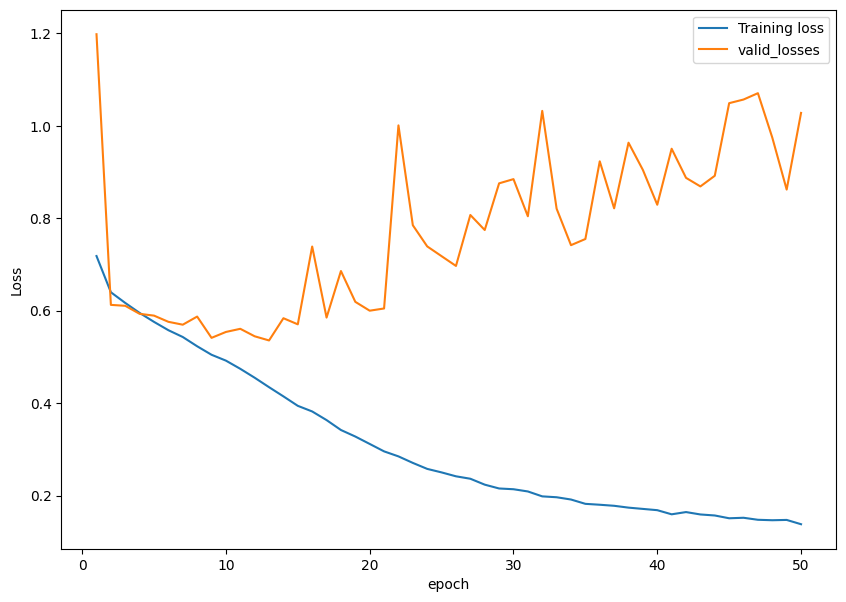

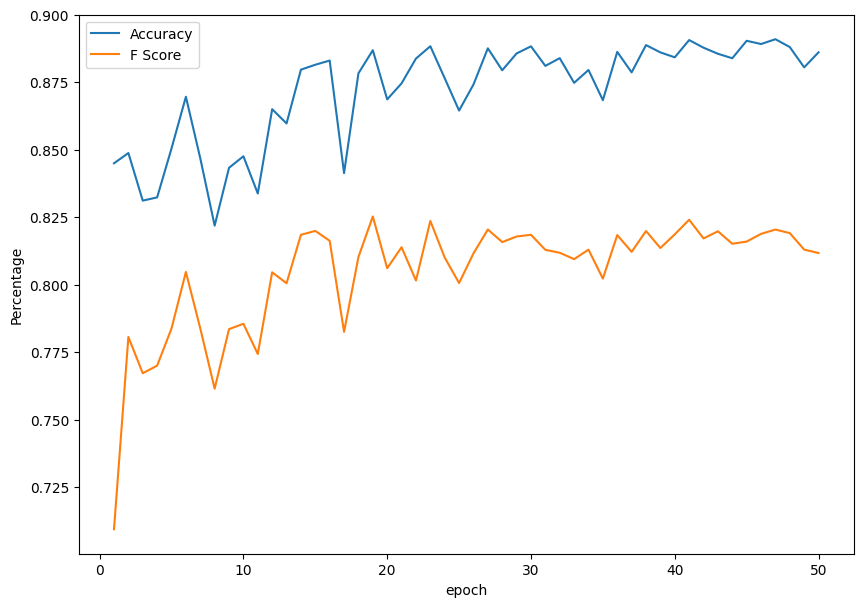

In [121]:
plot_loss(train_losses_6, valid_losses_6, 50)
plot_accurate(accuracies_6, f_scores_6, 50)

### base_6 prediction accuracy and f1 score

In [122]:
test_loss_6, accuracy_6, f_score_6 = test_model(base_6, test_loader4, criterion6, test = True, device = device, pt_name ='base_6.pt', network = Net())

Test Accuracy: 0.856927 	Test F Score: 0.798801


### Build model base_7

In [124]:
base_7 = Net2().to(device)
criterion7 = criterion
optimizer7 = optim.Adam(base_7.parameters(), lr = .002)

### Train base_7

In [125]:
train_losses_7, valid_losses_7, accuracies_7, f_scores_7 = train_model(base_7, train_loader4, val_loader4, 40, optimizer7, criterion7, model_name = 'base_6')

Epoch: 1/40, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [03:32<00:00,  4.42it/s]


Validation starts!
Epoch: 1 	Training Loss: 0.751124 	Validation Loss: 0.663234 	Validation Accuracy: 0.804255 	F_score: 0.738602
Time of Epoch: 4 minutes 13 seconds
Validation loss decreased (inf --> 0.663234). Saving model ...


Epoch: 2/40, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:16<00:00,  6.90it/s]


Validation starts!
Epoch: 2 	Training Loss: 0.651497 	Validation Loss: 0.613031 	Validation Accuracy: 0.801581 	F_score: 0.740996
Time of Epoch: 2 minutes 43 seconds
Validation loss decreased (0.663234 --> 0.613031). Saving model ...


Epoch: 3/40, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:17<00:00,  6.86it/s]


Validation starts!
Epoch: 3 	Training Loss: 0.627653 	Validation Loss: 0.655651 	Validation Accuracy: 0.850527 	F_score: 0.780690
Time of Epoch: 2 minutes 45 seconds


Epoch: 4/40, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:32<00:00,  6.16it/s]


Validation starts!
Epoch: 4 	Training Loss: 0.610593 	Validation Loss: 0.621840 	Validation Accuracy: 0.863626 	F_score: 0.795870
Time of Epoch: 3 minutes 3 seconds


Epoch: 5/40, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:28<00:00,  6.36it/s]


Validation starts!
Epoch: 5 	Training Loss: 0.592232 	Validation Loss: 0.584735 	Validation Accuracy: 0.830685 	F_score: 0.767792
Time of Epoch: 2 minutes 58 seconds
Validation loss decreased (0.613031 --> 0.584735). Saving model ...


Epoch: 6/40, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:28<00:00,  6.35it/s]


Validation starts!
Epoch: 6 	Training Loss: 0.572223 	Validation Loss: 0.690599 	Validation Accuracy: 0.855991 	F_score: 0.777990
Time of Epoch: 2 minutes 58 seconds


Epoch: 7/40, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:27<00:00,  6.38it/s]


Validation starts!
Epoch: 7 	Training Loss: 0.556050 	Validation Loss: 0.577639 	Validation Accuracy: 0.873120 	F_score: 0.808717
Time of Epoch: 2 minutes 57 seconds
Validation loss decreased (0.584735 --> 0.577639). Saving model ...


Epoch: 8/40, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:27<00:00,  6.38it/s]


Validation starts!
Epoch: 8 	Training Loss: 0.538154 	Validation Loss: 0.579372 	Validation Accuracy: 0.874826 	F_score: 0.809057
Time of Epoch: 2 minutes 56 seconds


Epoch: 9/40, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:25<00:00,  6.47it/s]


Validation starts!
Epoch: 9 	Training Loss: 0.518078 	Validation Loss: 0.557221 	Validation Accuracy: 0.867269 	F_score: 0.804788
Time of Epoch: 2 minutes 52 seconds
Validation loss decreased (0.577639 --> 0.557221). Saving model ...


Epoch: 10/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [03:07<00:00,  5.02it/s]


Validation starts!
Epoch: 10 	Training Loss: 0.500940 	Validation Loss: 0.588826 	Validation Accuracy: 0.862541 	F_score: 0.799752
Time of Epoch: 3 minutes 49 seconds


Epoch: 11/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [03:32<00:00,  4.43it/s]


Validation starts!
Epoch: 11 	Training Loss: 0.481896 	Validation Loss: 0.569115 	Validation Accuracy: 0.829523 	F_score: 0.768802
Time of Epoch: 4 minutes 12 seconds


Epoch: 12/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:50<00:00,  5.51it/s]


Validation starts!
Epoch: 12 	Training Loss: 0.453557 	Validation Loss: 0.586111 	Validation Accuracy: 0.890560 	F_score: 0.828516
Time of Epoch: 3 minutes 18 seconds


Epoch: 13/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:17<00:00,  6.84it/s]


Validation starts!
Epoch: 13 	Training Loss: 0.419725 	Validation Loss: 0.587585 	Validation Accuracy: 0.817664 	F_score: 0.758334
Time of Epoch: 2 minutes 44 seconds


Epoch: 14/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:17<00:00,  6.82it/s]


Validation starts!
Epoch: 14 	Training Loss: 0.382580 	Validation Loss: 0.747292 	Validation Accuracy: 0.874167 	F_score: 0.808290
Time of Epoch: 2 minutes 45 seconds


Epoch: 15/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:18<00:00,  6.78it/s]


Validation starts!
Epoch: 15 	Training Loss: 0.342565 	Validation Loss: 0.794096 	Validation Accuracy: 0.848202 	F_score: 0.780326
Time of Epoch: 2 minutes 45 seconds


Epoch: 16/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:17<00:00,  6.85it/s]


Validation starts!
Epoch: 16 	Training Loss: 0.305754 	Validation Loss: 0.842856 	Validation Accuracy: 0.776314 	F_score: 0.719615
Time of Epoch: 2 minutes 44 seconds


Epoch: 17/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:17<00:00,  6.82it/s]


Validation starts!
Epoch: 17 	Training Loss: 0.273588 	Validation Loss: 0.748732 	Validation Accuracy: 0.846070 	F_score: 0.783660
Time of Epoch: 2 minutes 44 seconds


Epoch: 18/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:17<00:00,  6.85it/s]


Validation starts!
Epoch: 18 	Training Loss: 0.241625 	Validation Loss: 0.825837 	Validation Accuracy: 0.885522 	F_score: 0.821100
Time of Epoch: 2 minutes 44 seconds


Epoch: 19/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:17<00:00,  6.82it/s]


Validation starts!
Epoch: 19 	Training Loss: 0.218033 	Validation Loss: 0.704070 	Validation Accuracy: 0.851263 	F_score: 0.790525
Time of Epoch: 2 minutes 45 seconds


Epoch: 20/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:17<00:00,  6.83it/s]


Validation starts!
Epoch: 20 	Training Loss: 0.195415 	Validation Loss: 1.038644 	Validation Accuracy: 0.885173 	F_score: 0.814847
Time of Epoch: 2 minutes 45 seconds


Epoch: 21/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:18<00:00,  6.80it/s]


Validation starts!
Epoch: 21 	Training Loss: 0.180582 	Validation Loss: 0.718586 	Validation Accuracy: 0.888777 	F_score: 0.822357
Time of Epoch: 2 minutes 45 seconds


Epoch: 22/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:18<00:00,  6.80it/s]


Validation starts!
Epoch: 22 	Training Loss: 0.156774 	Validation Loss: 0.812128 	Validation Accuracy: 0.876027 	F_score: 0.814669
Time of Epoch: 2 minutes 45 seconds


Epoch: 23/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:18<00:00,  6.79it/s]


Validation starts!
Epoch: 23 	Training Loss: 0.142931 	Validation Loss: 1.206272 	Validation Accuracy: 0.892071 	F_score: 0.820658
Time of Epoch: 2 minutes 45 seconds


Epoch: 24/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:19<00:00,  6.72it/s]


Validation starts!
Epoch: 24 	Training Loss: 0.135245 	Validation Loss: 0.857822 	Validation Accuracy: 0.876647 	F_score: 0.815681
Time of Epoch: 2 minutes 47 seconds


Epoch: 25/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:18<00:00,  6.78it/s]


Validation starts!
Epoch: 25 	Training Loss: 0.124595 	Validation Loss: 1.048981 	Validation Accuracy: 0.887808 	F_score: 0.823809
Time of Epoch: 2 minutes 46 seconds


Epoch: 26/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:18<00:00,  6.80it/s]


Validation starts!
Epoch: 26 	Training Loss: 0.122129 	Validation Loss: 0.891299 	Validation Accuracy: 0.883661 	F_score: 0.819266
Time of Epoch: 2 minutes 45 seconds


Epoch: 27/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:18<00:00,  6.81it/s]


Validation starts!
Epoch: 27 	Training Loss: 0.111294 	Validation Loss: 0.943829 	Validation Accuracy: 0.891025 	F_score: 0.825493
Time of Epoch: 2 minutes 45 seconds


Epoch: 28/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:18<00:00,  6.80it/s]


Validation starts!
Epoch: 28 	Training Loss: 0.106437 	Validation Loss: 0.895472 	Validation Accuracy: 0.886452 	F_score: 0.821820
Time of Epoch: 2 minutes 45 seconds


Epoch: 29/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:17<00:00,  6.82it/s]


Validation starts!
Epoch: 29 	Training Loss: 0.097985 	Validation Loss: 0.976910 	Validation Accuracy: 0.883429 	F_score: 0.815392
Time of Epoch: 2 minutes 44 seconds


Epoch: 30/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:18<00:00,  6.81it/s]


Validation starts!
Epoch: 30 	Training Loss: 0.094278 	Validation Loss: 1.055770 	Validation Accuracy: 0.889785 	F_score: 0.823266
Time of Epoch: 2 minutes 45 seconds


Epoch: 31/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:18<00:00,  6.80it/s]


Validation starts!
Epoch: 31 	Training Loss: 0.090618 	Validation Loss: 1.275604 	Validation Accuracy: 0.884165 	F_score: 0.809800
Time of Epoch: 2 minutes 46 seconds


Epoch: 32/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:18<00:00,  6.80it/s]


Validation starts!
Epoch: 32 	Training Loss: 0.089089 	Validation Loss: 1.032687 	Validation Accuracy: 0.893195 	F_score: 0.826971
Time of Epoch: 2 minutes 45 seconds


Epoch: 33/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:18<00:00,  6.80it/s]


Validation starts!
Epoch: 33 	Training Loss: 0.089635 	Validation Loss: 1.042993 	Validation Accuracy: 0.889242 	F_score: 0.816959
Time of Epoch: 2 minutes 45 seconds


Epoch: 34/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:18<00:00,  6.81it/s]


Validation starts!
Epoch: 34 	Training Loss: 0.080980 	Validation Loss: 1.251863 	Validation Accuracy: 0.892187 	F_score: 0.820863
Time of Epoch: 2 minutes 45 seconds


Epoch: 35/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:18<00:00,  6.82it/s]


Validation starts!
Epoch: 35 	Training Loss: 0.078961 	Validation Loss: 0.924024 	Validation Accuracy: 0.878120 	F_score: 0.807303
Time of Epoch: 2 minutes 45 seconds


Epoch: 36/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:18<00:00,  6.81it/s]


Validation starts!
Epoch: 36 	Training Loss: 0.084099 	Validation Loss: 1.170316 	Validation Accuracy: 0.893466 	F_score: 0.818703
Time of Epoch: 2 minutes 45 seconds


Epoch: 37/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:18<00:00,  6.79it/s]


Validation starts!
Epoch: 37 	Training Loss: 0.074437 	Validation Loss: 1.768957 	Validation Accuracy: 0.888041 	F_score: 0.804308
Time of Epoch: 2 minutes 45 seconds


Epoch: 38/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:18<00:00,  6.80it/s]


Validation starts!
Epoch: 38 	Training Loss: 0.072999 	Validation Loss: 1.004425 	Validation Accuracy: 0.885832 	F_score: 0.816745
Time of Epoch: 2 minutes 45 seconds


Epoch: 39/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:18<00:00,  6.81it/s]


Validation starts!
Epoch: 39 	Training Loss: 0.072103 	Validation Loss: 1.253226 	Validation Accuracy: 0.887924 	F_score: 0.812524
Time of Epoch: 2 minutes 45 seconds


Epoch: 40/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:17<00:00,  6.82it/s]


Validation starts!
Epoch: 40 	Training Loss: 0.071021 	Validation Loss: 1.222611 	Validation Accuracy: 0.885870 	F_score: 0.804462
Time of Epoch: 2 minutes 45 seconds


### Plot base_7

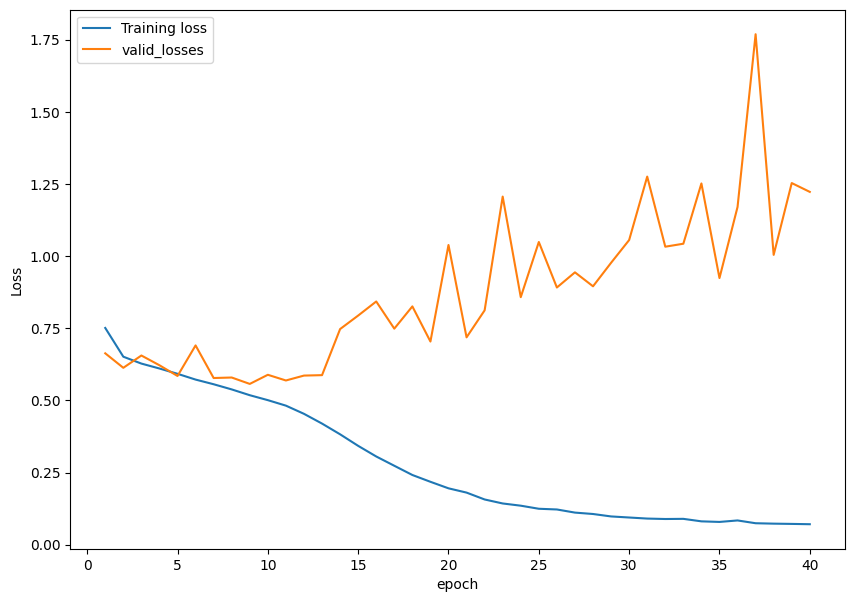

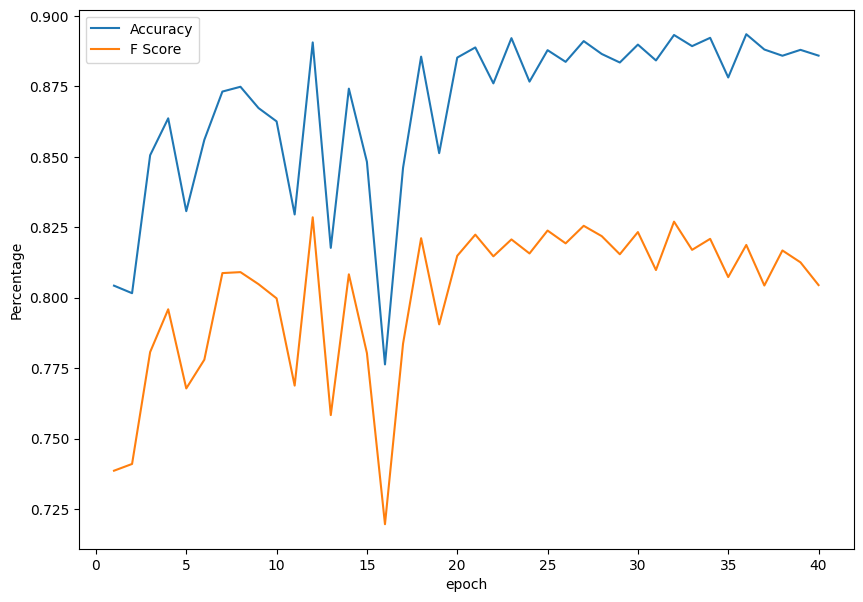

In [126]:
plot_loss(train_losses_7, valid_losses_7, 40)
plot_accurate(accuracies_7, f_scores_7, 40)

### base_7 prediction accuracy and f1 score

In [127]:
test_loss_7, accuracy_7, f_score_7 = test_model(base_7, test_loader4, criterion7, test = True, device = device, pt_name ='base_7.pt', network = Net2())

Test Accuracy: 0.865065 	Test F Score: 0.803743


### Build model base_8

In [140]:
base_8 = Net2().to(device)
pos_weight8 = torch.tensor([3.0])
criterion8 = nn.BCEWithLogitsLoss(pos_weight = pos_weight8).to(device)
optimizer8 = optim.Adam(base_8.parameters(), lr = .002)

### Train base_8

In [141]:
train_losses_8, valid_losses_8, accuracies_8, f_scores_8 = train_model(base_8, train_loader4, val_loader4, 40, optimizer8, criterion8, model_name = 'base_8')

Epoch: 1/40, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:20<00:00,  6.69it/s]


Validation starts!
Epoch: 1 	Training Loss: 0.686244 	Validation Loss: 0.560503 	Validation Accuracy: 0.824213 	F_score: 0.756024
Time of Epoch: 2 minutes 58 seconds
Validation loss decreased (inf --> 0.560503). Saving model ...


Epoch: 2/40, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:41<00:00,  5.82it/s]


Validation starts!
Epoch: 2 	Training Loss: 0.576701 	Validation Loss: 0.542662 	Validation Accuracy: 0.815726 	F_score: 0.752769
Time of Epoch: 3 minutes 8 seconds
Validation loss decreased (0.560503 --> 0.542662). Saving model ...


Epoch: 3/40, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:17<00:00,  6.84it/s]


Validation starts!
Epoch: 3 	Training Loss: 0.551825 	Validation Loss: 0.516576 	Validation Accuracy: 0.856766 	F_score: 0.788049
Time of Epoch: 2 minutes 44 seconds
Validation loss decreased (0.542662 --> 0.516576). Saving model ...


Epoch: 4/40, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:23<00:00,  6.57it/s]


Validation starts!
Epoch: 4 	Training Loss: 0.531624 	Validation Loss: 0.507404 	Validation Accuracy: 0.860022 	F_score: 0.794446
Time of Epoch: 3 minutes 4 seconds
Validation loss decreased (0.516576 --> 0.507404). Saving model ...


Epoch: 5/40, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:46<00:00,  5.66it/s]


Validation starts!
Epoch: 5 	Training Loss: 0.517658 	Validation Loss: 0.519996 	Validation Accuracy: 0.865525 	F_score: 0.799376
Time of Epoch: 3 minutes 12 seconds


Epoch: 6/40, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:23<00:00,  6.54it/s]


Validation starts!
Epoch: 6 	Training Loss: 0.502931 	Validation Loss: 0.559043 	Validation Accuracy: 0.877616 	F_score: 0.803656
Time of Epoch: 2 minutes 50 seconds


Epoch: 7/40, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:19<00:00,  6.76it/s]


Validation starts!
Epoch: 7 	Training Loss: 0.492152 	Validation Loss: 0.477361 	Validation Accuracy: 0.849868 	F_score: 0.789250
Time of Epoch: 2 minutes 45 seconds
Validation loss decreased (0.507404 --> 0.477361). Saving model ...


Epoch: 8/40, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:20<00:00,  6.70it/s]


Validation starts!
Epoch: 8 	Training Loss: 0.471259 	Validation Loss: 0.489703 	Validation Accuracy: 0.877926 	F_score: 0.810834
Time of Epoch: 2 minutes 46 seconds


Epoch: 9/40, Batch: 940/941: 100%|██████████████████████████████████████████████████| 941/941 [02:19<00:00,  6.73it/s]


Validation starts!
Epoch: 9 	Training Loss: 0.458965 	Validation Loss: 0.500454 	Validation Accuracy: 0.880639 	F_score: 0.814748
Time of Epoch: 2 minutes 46 seconds


Epoch: 10/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:20<00:00,  6.68it/s]


Validation starts!
Epoch: 10 	Training Loss: 0.439449 	Validation Loss: 0.863035 	Validation Accuracy: 0.868160 	F_score: 0.759099
Time of Epoch: 2 minutes 48 seconds


Epoch: 11/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:20<00:00,  6.70it/s]


Validation starts!
Epoch: 11 	Training Loss: 0.424060 	Validation Loss: 0.468283 	Validation Accuracy: 0.842893 	F_score: 0.783671
Time of Epoch: 2 minutes 46 seconds
Validation loss decreased (0.477361 --> 0.468283). Saving model ...


Epoch: 12/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:19<00:00,  6.76it/s]


Validation starts!
Epoch: 12 	Training Loss: 0.402863 	Validation Loss: 0.499107 	Validation Accuracy: 0.867501 	F_score: 0.804125
Time of Epoch: 2 minutes 46 seconds


Epoch: 13/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:19<00:00,  6.72it/s]


Validation starts!
Epoch: 13 	Training Loss: 0.390135 	Validation Loss: 0.448851 	Validation Accuracy: 0.865718 	F_score: 0.805523
Time of Epoch: 2 minutes 46 seconds
Validation loss decreased (0.468283 --> 0.448851). Saving model ...


Epoch: 14/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:19<00:00,  6.72it/s]


Validation starts!
Epoch: 14 	Training Loss: 0.362341 	Validation Loss: 0.461717 	Validation Accuracy: 0.851767 	F_score: 0.792627
Time of Epoch: 2 minutes 46 seconds


Epoch: 15/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:21<00:00,  6.65it/s]


Validation starts!
Epoch: 15 	Training Loss: 0.331909 	Validation Loss: 0.471858 	Validation Accuracy: 0.864750 	F_score: 0.804438
Time of Epoch: 2 minutes 47 seconds


Epoch: 16/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:19<00:00,  6.76it/s]


Validation starts!
Epoch: 16 	Training Loss: 0.302440 	Validation Loss: 0.572171 	Validation Accuracy: 0.884708 	F_score: 0.823264
Time of Epoch: 2 minutes 45 seconds


Epoch: 17/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:18<00:00,  6.80it/s]


Validation starts!
Epoch: 17 	Training Loss: 0.274675 	Validation Loss: 0.496559 	Validation Accuracy: 0.879321 	F_score: 0.818510
Time of Epoch: 2 minutes 44 seconds


Epoch: 18/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:19<00:00,  6.75it/s]


Validation starts!
Epoch: 18 	Training Loss: 0.237259 	Validation Loss: 0.541511 	Validation Accuracy: 0.868121 	F_score: 0.808184
Time of Epoch: 2 minutes 45 seconds


Epoch: 19/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:32<00:00,  6.19it/s]


Validation starts!
Epoch: 19 	Training Loss: 0.212984 	Validation Loss: 0.758115 	Validation Accuracy: 0.896450 	F_score: 0.826155
Time of Epoch: 2 minutes 59 seconds


Epoch: 20/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:10<00:00,  7.19it/s]


Validation starts!
Epoch: 20 	Training Loss: 0.188950 	Validation Loss: 0.632784 	Validation Accuracy: 0.888467 	F_score: 0.826355
Time of Epoch: 2 minutes 38 seconds


Epoch: 21/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:12<00:00,  7.09it/s]


Validation starts!
Epoch: 21 	Training Loss: 0.169425 	Validation Loss: 0.716639 	Validation Accuracy: 0.870563 	F_score: 0.804152
Time of Epoch: 2 minutes 39 seconds


Epoch: 22/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:11<00:00,  7.14it/s]


Validation starts!
Epoch: 22 	Training Loss: 0.154769 	Validation Loss: 0.764880 	Validation Accuracy: 0.891296 	F_score: 0.823173
Time of Epoch: 2 minutes 38 seconds


Epoch: 23/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:10<00:00,  7.21it/s]


Validation starts!
Epoch: 23 	Training Loss: 0.136609 	Validation Loss: 0.734004 	Validation Accuracy: 0.868121 	F_score: 0.803918
Time of Epoch: 2 minutes 36 seconds


Epoch: 24/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:13<00:00,  7.05it/s]


Validation starts!
Epoch: 24 	Training Loss: 0.123207 	Validation Loss: 1.019020 	Validation Accuracy: 0.895094 	F_score: 0.819425
Time of Epoch: 2 minutes 39 seconds


Epoch: 25/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:12<00:00,  7.09it/s]


Validation starts!
Epoch: 25 	Training Loss: 0.111571 	Validation Loss: 1.057404 	Validation Accuracy: 0.892691 	F_score: 0.818533
Time of Epoch: 2 minutes 38 seconds


Epoch: 26/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:13<00:00,  7.04it/s]


Validation starts!
Epoch: 26 	Training Loss: 0.111482 	Validation Loss: 0.847379 	Validation Accuracy: 0.883971 	F_score: 0.814888
Time of Epoch: 2 minutes 40 seconds


Epoch: 27/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:12<00:00,  7.10it/s]


Validation starts!
Epoch: 27 	Training Loss: 0.097299 	Validation Loss: 0.753376 	Validation Accuracy: 0.868896 	F_score: 0.804891
Time of Epoch: 2 minutes 38 seconds


Epoch: 28/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:12<00:00,  7.08it/s]


Validation starts!
Epoch: 28 	Training Loss: 0.100106 	Validation Loss: 1.116094 	Validation Accuracy: 0.894086 	F_score: 0.818923
Time of Epoch: 2 minutes 38 seconds


Epoch: 29/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:10<00:00,  7.18it/s]


Validation starts!
Epoch: 29 	Training Loss: 0.086025 	Validation Loss: 0.992551 	Validation Accuracy: 0.890831 	F_score: 0.817374
Time of Epoch: 2 minutes 36 seconds


Epoch: 30/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:11<00:00,  7.15it/s]


Validation starts!
Epoch: 30 	Training Loss: 0.087638 	Validation Loss: 0.784768 	Validation Accuracy: 0.876957 	F_score: 0.811472
Time of Epoch: 2 minutes 37 seconds


Epoch: 31/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:13<00:00,  7.03it/s]


Validation starts!
Epoch: 31 	Training Loss: 0.078372 	Validation Loss: 0.853875 	Validation Accuracy: 0.881995 	F_score: 0.810811
Time of Epoch: 2 minutes 40 seconds


Epoch: 32/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:31<00:00,  6.23it/s]


Validation starts!
Epoch: 32 	Training Loss: 0.075830 	Validation Loss: 0.855955 	Validation Accuracy: 0.877810 	F_score: 0.813443
Time of Epoch: 2 minutes 58 seconds


Epoch: 33/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:14<00:00,  7.01it/s]


Validation starts!
Epoch: 33 	Training Loss: 0.077104 	Validation Loss: 0.893401 	Validation Accuracy: 0.892226 	F_score: 0.827127
Time of Epoch: 2 minutes 40 seconds


Epoch: 34/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:13<00:00,  7.06it/s]


Validation starts!
Epoch: 34 	Training Loss: 0.072172 	Validation Loss: 0.807465 	Validation Accuracy: 0.878817 	F_score: 0.814718
Time of Epoch: 2 minutes 39 seconds


Epoch: 35/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:13<00:00,  7.06it/s]


Validation starts!
Epoch: 35 	Training Loss: 0.066727 	Validation Loss: 1.018699 	Validation Accuracy: 0.875833 	F_score: 0.813786
Time of Epoch: 2 minutes 38 seconds


Epoch: 36/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:13<00:00,  7.03it/s]


Validation starts!
Epoch: 36 	Training Loss: 0.066999 	Validation Loss: 0.826097 	Validation Accuracy: 0.881414 	F_score: 0.807982
Time of Epoch: 2 minutes 40 seconds


Epoch: 37/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:17<00:00,  6.84it/s]


Validation starts!
Epoch: 37 	Training Loss: 0.064167 	Validation Loss: 1.174303 	Validation Accuracy: 0.889281 	F_score: 0.814034
Time of Epoch: 2 minutes 43 seconds


Epoch: 38/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:20<00:00,  6.69it/s]


Validation starts!
Epoch: 38 	Training Loss: 0.063977 	Validation Loss: 1.161666 	Validation Accuracy: 0.889823 	F_score: 0.807580
Time of Epoch: 2 minutes 49 seconds


Epoch: 39/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [03:08<00:00,  5.00it/s]


Validation starts!
Epoch: 39 	Training Loss: 0.059720 	Validation Loss: 1.386574 	Validation Accuracy: 0.889707 	F_score: 0.813304
Time of Epoch: 3 minutes 47 seconds


Epoch: 40/40, Batch: 940/941: 100%|█████████████████████████████████████████████████| 941/941 [02:21<00:00,  6.65it/s]


Validation starts!
Epoch: 40 	Training Loss: 0.061053 	Validation Loss: 1.113322 	Validation Accuracy: 0.874206 	F_score: 0.810486
Time of Epoch: 2 minutes 47 seconds


### Plot base_8

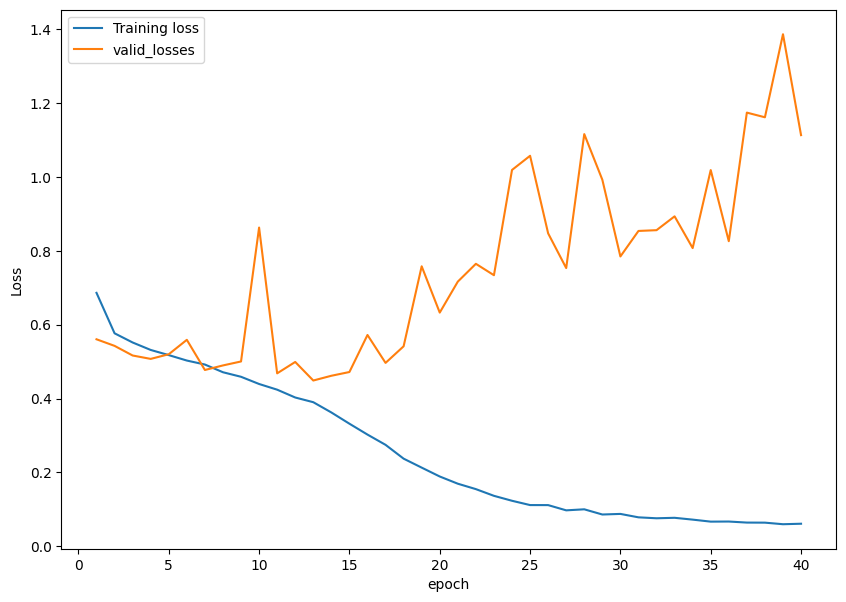

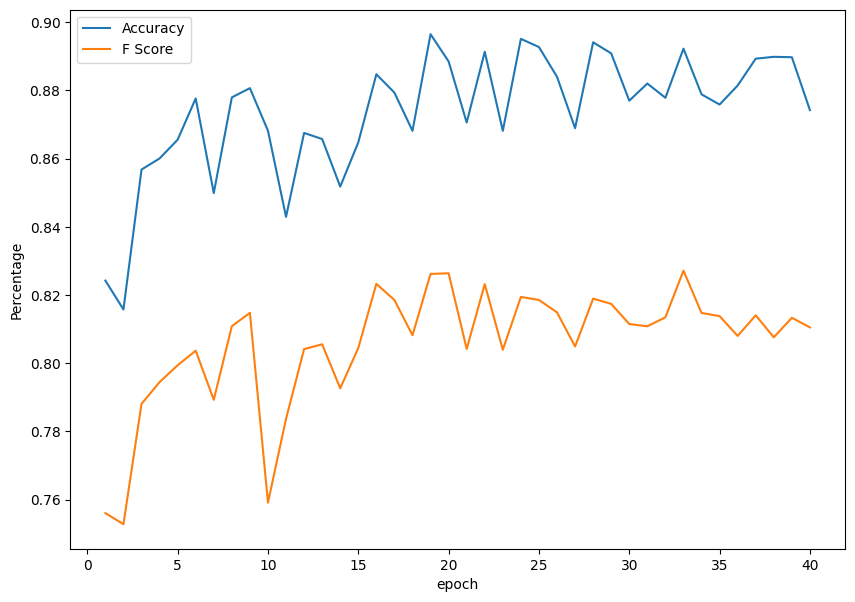

In [142]:
plot_loss(train_losses_8, valid_losses_8, 40)
plot_accurate(accuracies_8, f_scores_8, 40)

### base_8 prediction accuracy and f1 score

In [143]:
test_loss_8, accuracy_8, f_score_8 = test_model(base_8, test_loader4, criterion8, test = True, device = device, pt_name ='base_8.pt', network = Net2())

Test Accuracy: 0.861810 	Test F Score: 0.802481


### Architecture 4: NetChi3

In [ ]:
class NetChi3(nn.Module):
    def __init__(self):
        super(NetChi3, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding = 1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.2)

        self.fc1 = nn.Linear(256*8*8, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 1)
        

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 256*8*8)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return x
    

### Build model Chi3_tune

In [ ]:
Chi3_tune = NetChi3().to(device)
Chi3_tune
# specify loss function (categorical cross-entropy)
pos_weight = torch.tensor([4.0])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)

# specify optimizer
optimizer = optim.Adam(Chi3_tune.parameters(), lr=0.007)

### Train Chi3_tune

In [ ]:
train_losses_chi3, valid_losses_chi3, accuracies_chi3, f_scores_chi3 = train_model(Chi3_tune, train_loader, val_loader, 30, optimizer, criterion, model_name = 'Chi3_tune')

### Chi3_tune prediction accuracy and f1 score

In [ ]:
test_loss_chi3, accuracy_chi3, f_score_chi3 = test_model(Chi3_tune, test_loader, criterion, test = True, device = device, pt_name ='/Chi3_tune.pt', network = Chi3_tune)

### Build model Chi4_tune

In [ ]:
Chi4_tune = NetChi3().to(device)
Chi4_tune
# specify loss function (categorical cross-entropy)
pos_weight = torch.tensor([4.0])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)

# specify optimizer
optimizer = optim.Adam(Chi4_tune.parameters(), lr=0.003)

### Train Chi4_tune

In [ ]:
train_losses_chi4, valid_losses_chi4, accuracies_chi4, f_scores_chi4 = train_model(Chi4_tune, train_loader, val_loader, 30, optimizer, criterion, model_name = 'Chi4_tune')

### Chi4_tune prediction accuracy and f1 score

In [ ]:
test_loss_chi4, accuracy_chi4, f_score_chi4 = test_model(Chi4_tune, test_loader, criterion, test = True, device = device, pt_name ='/Chi4_tune.pt', network = Chi3_tune)

### Null model accuracy with all prediction set to 0

In [152]:
positive = 0 
total_length = 0
for _, target in test_loader:
    positive += torch.sum(target).item()
    total_length += target.size(0)
null_accuracy = 1 - positive/total_length
null_accuracy

0.6954853710521216

### Lift of best model from baseline model

In [154]:
lift = accuracy_7 - null_accuracy
lift

0.1695795388490603